# Data preparation

Questo jnb rappresenta una prima esplorazione dei dati a disposizione, insieme al tenativo di pre-processarli con diverse tecniche di signal processing mutuate da diverse fonti (in particolare: https://bit.ly/2zQEeIg). I dati sono riorganizzati poi in una struttura consona per l'addestramento di un classificatore.

In [7]:
import os
import sys
import glob

import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [9]:
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import filtfilt

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [12]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

## 1. EDA Exploratory Data Analysis

#### 1.1. EDA singolo file

In [13]:
# importa un singolo file in un Dataframe di pandas
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [14]:
df.head()

0     1      2     3     4
0  20180920-15:24:10.452 -7464  16632  2060  2111
1  20180920-15:24:10.456  3976  17892 -6080  2115
2  20180920-15:24:10.458  -584  17500  1356  2124
3  20180920-15:24:10.460  -584  17500  1356  2142
4  20180920-15:24:10.462  -584  17500  1356  2143

In [15]:
# rinomina le feature del df
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [16]:
# trasforma il tipo della feature "date_time" nel formato date_time
df['date_time'] = pd.to_datetime(df['date_time'])

In [17]:
df.shape

(25575, 5)

In [18]:
df.head(10), df.tail(10)

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143
 5 2018-09-20 15:24:10.465   552  12740 -1860  2132
 6 2018-09-20 15:24:10.467   552  12740 -1860  2144
 7 2018-09-20 15:24:10.469 -7728  17280  1608  2133
 8 2018-09-20 15:24:10.471 -7728  17280  1608  2115
 9 2018-09-20 15:24:10.473  4628  17392 -6220  2097,
                     date_time     x      y     z     i
 25565 2018-09-20 15:25:11.984   224  16732   596  2217
 25566 2018-09-20 15:25:11.986 -3604  13988  1136  1975
 25567 2018-09-20 15:25:11.988 -3604  13988  1136  1807
 25568 2018-09-20 15:25:11.990  -980  17712 -3740  1760
 25569 2018-09-20 15:25:11.993  -980  17712 -3740  1937
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  114

Plottiamo le time series delle singole variabili misurate in un intervallo a scelta.

In [19]:
df.columns.values

array(['date_time', 'x', 'y', 'z', 'i'], dtype=object)

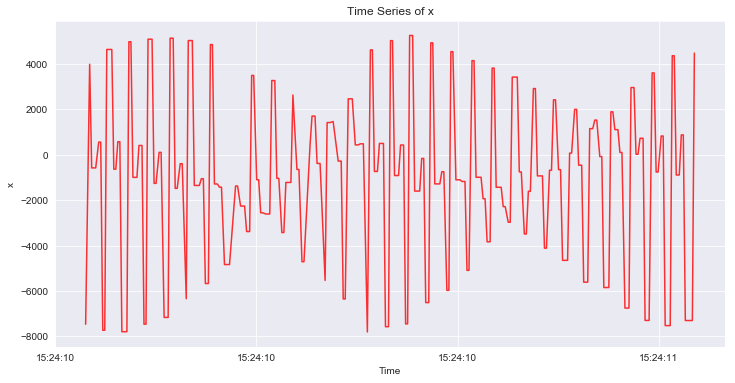

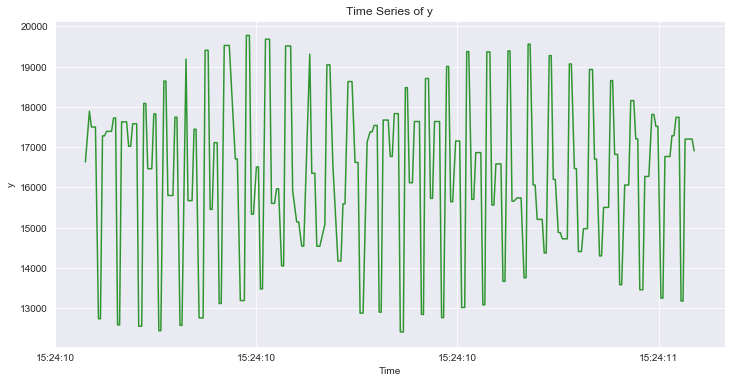

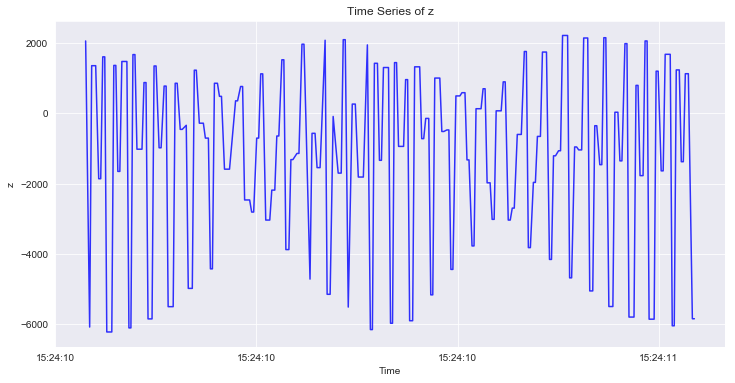

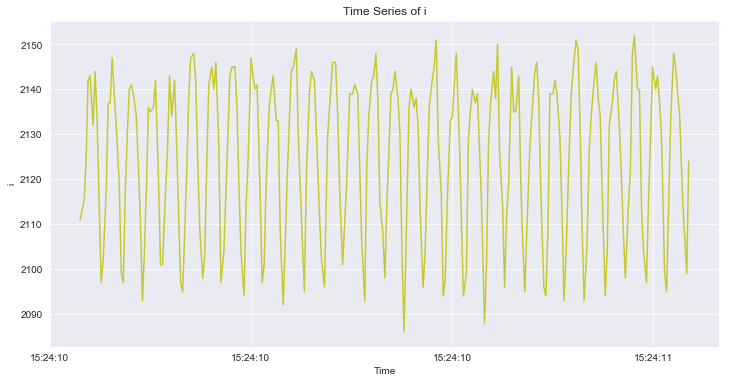

In [20]:
start_time = 0
end_time = 256
variables = df.columns.values[1:]
colors = {'x':'r', 'y':'g', 'z':'b', 'i':'y'}

for var in variables:
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x='date_time', y=var, data=df[start_time:end_time], color=colors[var], alpha=0.8)
    plt.title("Time Series of " + var)
    plt.xlabel("Time")
    plt.ylabel(var)

Plottiamo la distribuzione delle singole variabili.

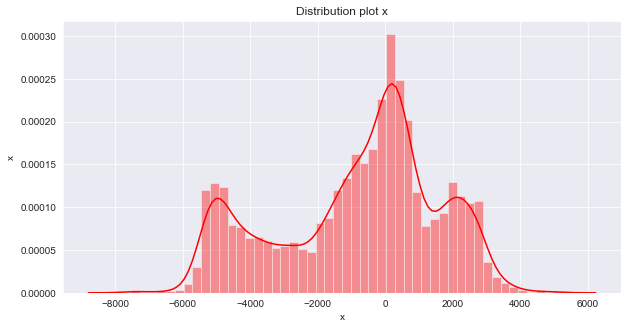

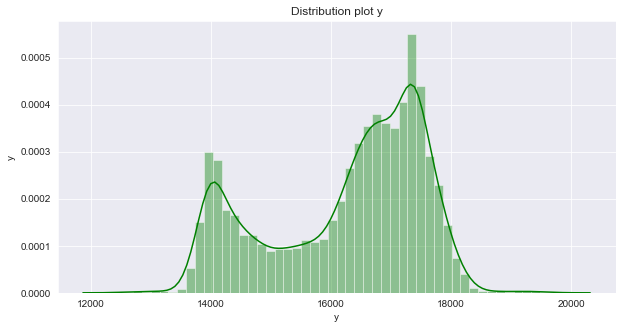

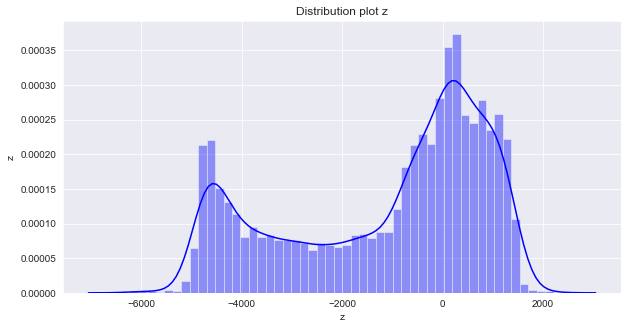

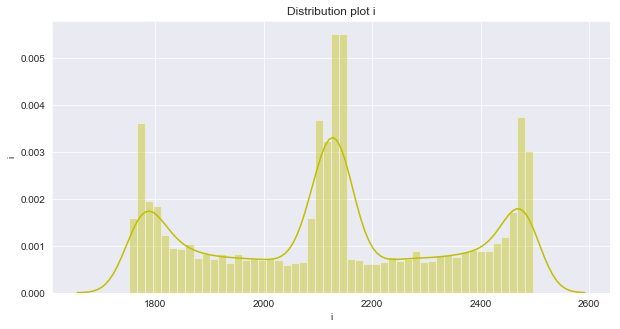

In [21]:
for var in variables:
    
    plt.figure(figsize=(10,5))
    sns.distplot(df[var], bins=50, color=colors[var], norm_hist=True)
    plt.title("Distribution plot " + var)
    plt.xlabel(var)
    plt.ylabel(var)

#### 1.2. EDA tutti i file

In [22]:
"""
importa tutti i file dei dati .csv, li etichetta
e li concatena in un unico dataframe
"""

all_files = glob.glob(data_path + "/*.csv")
all_files.sort()

dframe = pd.DataFrame()
f_list = []

for f in all_files:
    
    # skippa i campioni iniziali
    df = pd.read_csv(f, skiprows=1024, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # assegna la label a ciascun sub-dataframe
    df['label'] = f[f.rfind('\\') +1]
    f_list.append(df)
    
# concatena i singoli df
dframe = pd.concat(f_list)

In [23]:
dframe.head(), dframe.tail()

(                date_time     x      y     z     i label
 0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1
 1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1
 2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1
 3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1
 4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1,
                     date_time     x      y    z     i label
 24547 2018-09-20 15:28:58.065  1012  16352   28  2468     7
 24548 2018-09-20 15:28:58.067  1012  16352   28  2480     7
 24549 2018-09-20 15:28:58.069  1012  15024  780  2294     7
 24550 2018-09-20 15:28:58.071 -2012  15024  780  2070     7
 24551 2018-09-20 15:28:58.074 -2012  15024  780  1838     7)

In [240]:
24552+1024

25576

In [24]:
# elenca il numero di sample per classe dalla più numerosa
dframe.label.value_counts()

5    50127
2    24552
7    24552
6    14322
1     9207
3     9207
4     9207
Name: label, dtype: int64

In [242]:
dframe.isna().sum()

date_time    0
x            0
y            0
z            0
i            0
label        0
m            0
dtype: int64

([<matplotlib.axis.XTick at 0x2856d6ac048>,
 <a list of 7 Text xticklabel objects>)

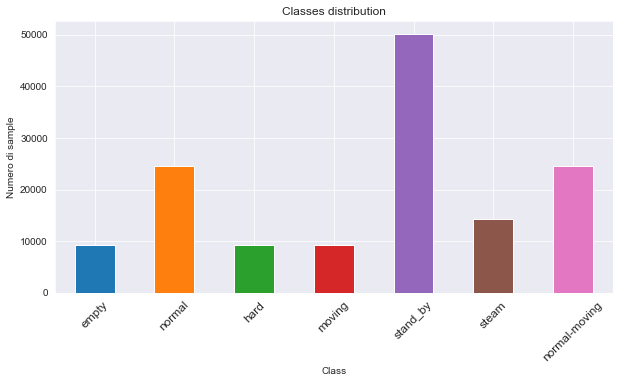

In [25]:
# plotta la distribuzione delle classi (numero di campioni per classe = modalità di funzionamento)
count_classes = pd.value_counts(dframe['label'], sort = True).sort_index()
plt.figure(figsize=(10,5))
count_classes.plot(kind = 'bar')
plt.title("Classes distribution")
plt.xlabel("Class")
plt.ylabel("Numero di sample")
#labels = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}
labels = ['empty', 'normal', 'hard', 'moving', 'stand_by', 'steam', 'normal-moving']
plt.xticks(range(0,7), labels, rotation=45, fontsize=12)

In [26]:
# prende la norma delle componenti del segnale lungo i tre assi
dframe['m'] = np.sqrt(dframe['x']**2 + dframe['y']**2 + dframe['z']**2)

In [27]:
dframe.head()

date_time     x      y     z     i label             m
0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1  14296.124230
1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1  16402.076942
2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1  16402.076942
3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1  19928.177037
4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1  19928.177037

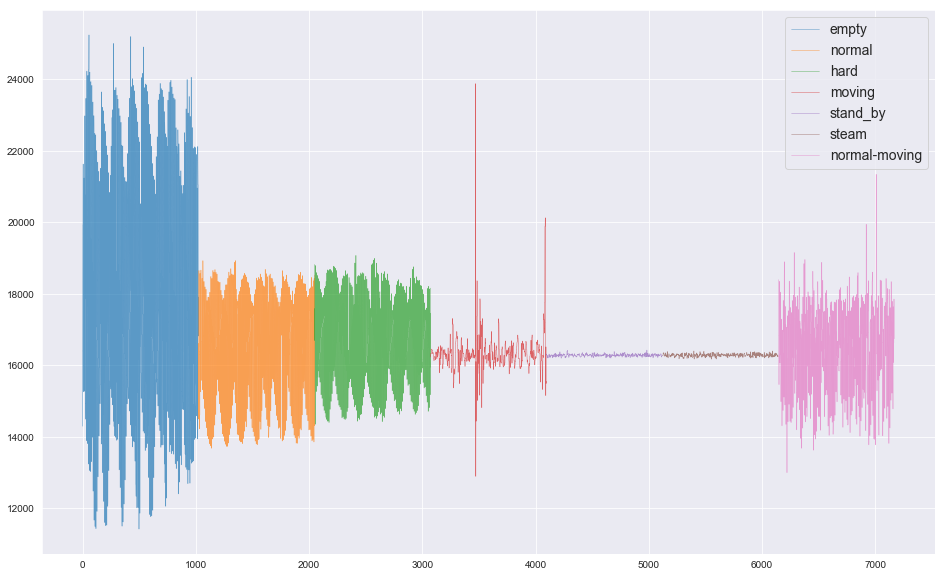

In [28]:
# plotta un certo numero di campioni per ogni modalità di funzionamento
# per visualizzare le forme d'onda 
start_sample = 0
end_sample = 1024

plt.figure(figsize=(16,10))

for c in range(1, 8):
    plt.plot(dframe[dframe['label'] == str(c)]['m'][start_sample:end_sample], 
             linewidth=.5, alpha=0.70)
    start_sample = end_sample
    end_sample = start_sample + 1024

plt.legend(labels, prop={'size': 14})

Visualizziamo le correlazioni tra le variabili x, y, z, raggruppate per label.

In [29]:
# ignora l'errore di divisione per zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [30]:
# genera il df per la visualizzazione a coppie
pair_df = dframe.loc[:, ['x','y','z','label']]

In [31]:
labels_dict = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}

In [32]:
pair_df['label'] = pair_df['label'].map(labels_dict)

In [33]:
pair_df.head()

x      y     z  label
0 -3888  13068 -4300  empty
1  -112  15828 -4300  empty
2  -112  15828 -4300  empty
3 -7380  18088  3936  empty
4 -7380  18088  3936  empty

In [34]:
col_labels_dict = {'empty':'C0', 'normal':'C1', 'hard':'C2', 'moving':'C3', 'stand_by':'C4',
              'steam':'C5', 'normal-moving':'C6'}

In [35]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [1, 2, 3]
hue_order = [labels_dict[str(i)] for i in sel_labels]

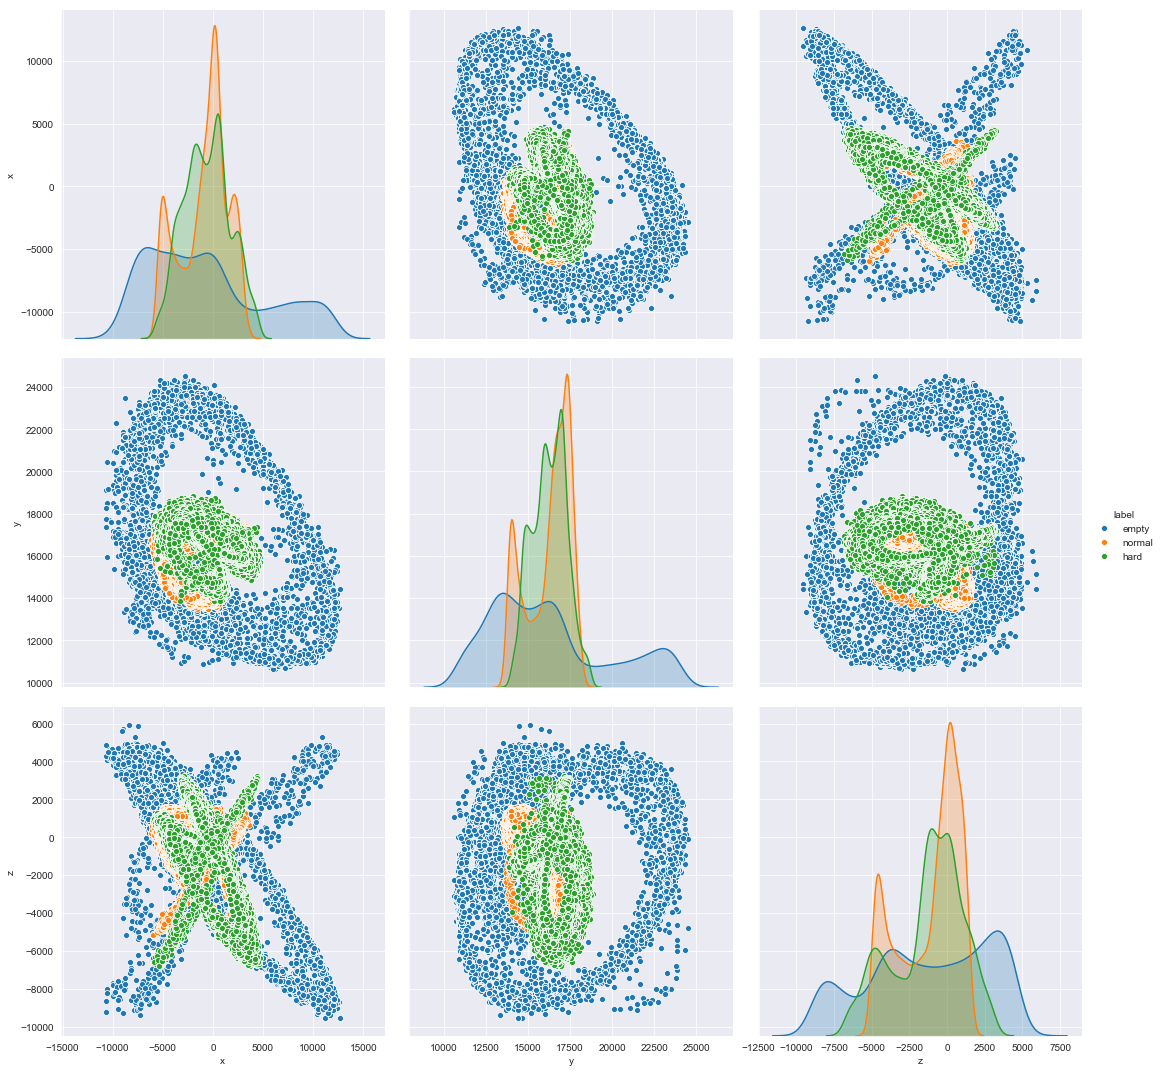

In [36]:
# rispetto alle prime tre label: empty, normal pouring, hard pouring
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

In [37]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [3, 4, 7]
hue_order = [labels_dict[str(i)] for i in sel_labels]

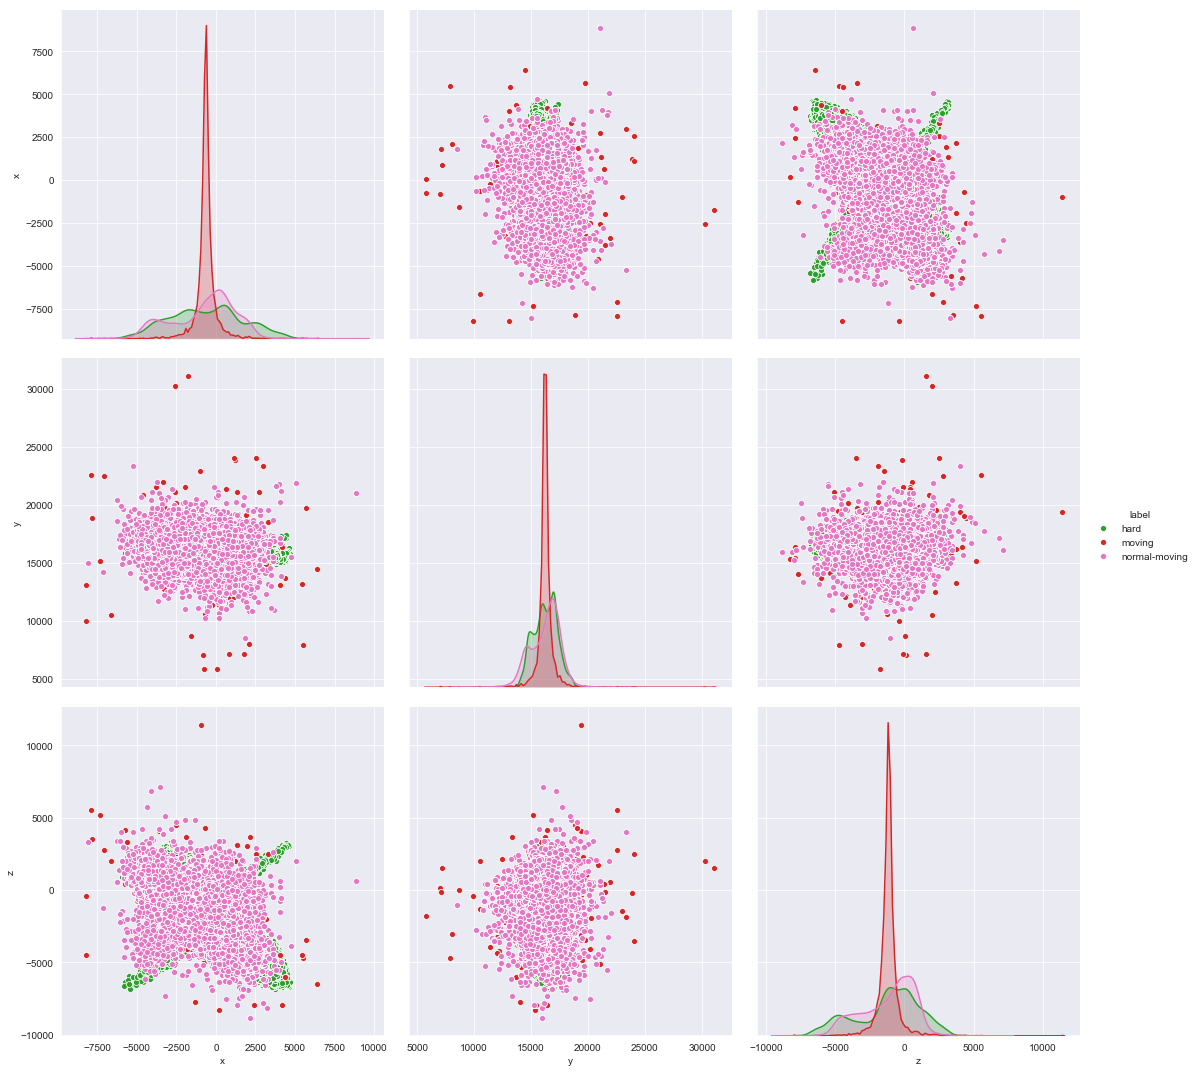

In [38]:
# rispetto alle label: hard pouring, moving, normal-moving
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

## 2. Pre-processing

### 2.1. Pre-processing FFT

Calcoliamo la FFT per il **singolo file.**

In [39]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [40]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [41]:
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [42]:
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [43]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [44]:
df.head(10), df.tail(10)

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143
 5 2018-09-20 15:24:10.465   552  12740 -1860  2132
 6 2018-09-20 15:24:10.467   552  12740 -1860  2144
 7 2018-09-20 15:24:10.469 -7728  17280  1608  2133
 8 2018-09-20 15:24:10.471 -7728  17280  1608  2115
 9 2018-09-20 15:24:10.473  4628  17392 -6220  2097,
                     date_time     x      y     z     i
 25565 2018-09-20 15:25:11.984   224  16732   596  2217
 25566 2018-09-20 15:25:11.986 -3604  13988  1136  1975
 25567 2018-09-20 15:25:11.988 -3604  13988  1136  1807
 25568 2018-09-20 15:25:11.990  -980  17712 -3740  1760
 25569 2018-09-20 15:25:11.993  -980  17712 -3740  1937
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  114

In [45]:
def get_signal_properties(df, start_time_idx, end_time_idx):
    
    """
    calcola alcune proprietà del segnale campionato
    
    parametri:
    ----------
    df : pandas dataframe contenente una colonna di tipo datetime
    start_time_idx = indice del primo istante della finestra temporale (campione)
    end_time_idx = indice dell'utlimo istante temporale
    
    return:
    -------
    N : numero di campioni
    delta_time_sec : durata in secondi dell'intervallo di campionamento
    T : periodo = delta_time_sec/N
    fs : frequenza di campionamento = 1/T   
    
    """
    
    df = df.reset_index()
    df = df[start_time_idx:end_time_idx]
    delta_time_sec = (df['date_time'][end_time_idx - 1] - df['date_time'][start_time_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    fs = round(1/T, 2)
    
    return N, delta_time_sec, T, fs

In [46]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=0, end_time_idx=128)

In [47]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.313 secondi
Il periodo è: 0.0024 secondi
La frequenza di campionamento è: 408.95 Hz


In [48]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=128, end_time_idx=256)

In [49]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(T))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.289 secondi
Il periodo è: 0.0022578125 secondi
La frequenza di campionamento è: 442.91 Hz


Come si può osservare, il segnale è campionato in modo irregolare. Per regolarizzarlo è necessario ricampionarlo

In [50]:
df.head()

date_time     x      y     z     i
0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
2 2018-09-20 15:24:10.458  -584  17500  1356  2124
3 2018-09-20 15:24:10.460  -584  17500  1356  2142
4 2018-09-20 15:24:10.462  -584  17500  1356  2143

In [51]:
df_tmp = df.set_index('date_time')

In [52]:
df_tmp.head()

x      y     z     i
date_time                                       
2018-09-20 15:24:10.452 -7464  16632  2060  2111
2018-09-20 15:24:10.456  3976  17892 -6080  2115
2018-09-20 15:24:10.458  -584  17500  1356  2124
2018-09-20 15:24:10.460  -584  17500  1356  2142
2018-09-20 15:24:10.462  -584  17500  1356  2143

Scegliamo un intervallo di 3 ms per non discostarci troppo dal range di frequenze del campionamento originale. In ogni caso possiamo scegliere un diverso intervallo temporale.

In [53]:
delta_ms = '3ms'

In [54]:
df_res = df_tmp.resample(delta_ms).asfreq().interpolate().dropna()

In [55]:
# verifica che non ci siano NaN nel segnale ricampionato
df_res.isna().sum()

x    0
y    0
z    0
i    0
dtype: int64

In [56]:
# ritorna alla precedente struttura del df
df_res = df_res.reset_index()

In [57]:
df_res.head(10)

date_time            x             y       z            i
0 2018-09-20 15:24:10.452 -7464.000000  16632.000000  2060.0  2111.000000
1 2018-09-20 15:24:10.455 -4024.000000  17066.000000  1708.0  2117.500000
2 2018-09-20 15:24:10.458  -584.000000  17500.000000  1356.0  2124.000000
3 2018-09-20 15:24:10.461  -205.333333  15913.333333   284.0  2130.666667
4 2018-09-20 15:24:10.464   173.333333  14326.666667  -788.0  2137.333333
5 2018-09-20 15:24:10.467   552.000000  12740.000000 -1860.0  2144.000000
6 2018-09-20 15:24:10.470  2590.000000  15066.000000 -4040.0  2120.500000
7 2018-09-20 15:24:10.473  4628.000000  17392.000000 -6220.0  2097.000000
8 2018-09-20 15:24:10.476  2872.000000  17502.666667 -3692.0  2110.333333
9 2018-09-20 15:24:10.479  1116.000000  17613.333333 -1164.0  2123.666667

Verifichiamo che il segnale ricampionato sia regolare prendendo diverse finestre (buffer) dello stesso numero di sample.

In [58]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=0, end_time_idx=128)

In [59]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [60]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=256, end_time_idx=384)

In [61]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


Applichiamo la trasformata veloce di Fourier per analizzare le componenti periodiche del segnale.

In [62]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [63]:
f_values.size

64

In [64]:
fft_values_ = fft(df_res['x'])
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [65]:
fft_values.size

64

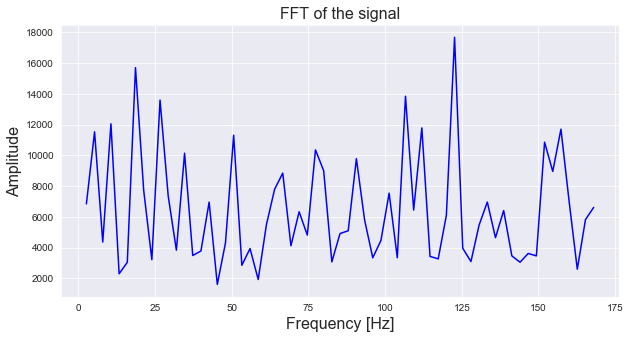

In [66]:
plt.figure(figsize=(10,5))
plt.plot(f_values[1:], fft_values[1:], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.show()

Attraverso la funzione di scipy, individuiamo i picchi nello spazio delle frequenze che rappresentano le frequenze alle quali avvengono le oscillazioni. Tali frequenze e le relative ampiezze ci consentono di caratterizzare ciascun tipo di segnale e quindi di estrarre delle feature per l'addestramento del classificatore.

In [67]:
x, y = f_values[1:], fft_values[1:]

In [68]:
# introduciamo una soglia di ampiezza pari all'1% della differenza tra il valore max e il val min
fft_threshold = 0.01*(np.max(y) - np.min(y))

In [69]:
# nb: la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(fft_values, threshold=fft_threshold,  distance=10)

In [70]:
peaks_ind

array([ 7, 19, 29, 46, 59], dtype=int64)

In [71]:
f_values[peaks_ind]

array([ 18.66433362,  50.66033412,  77.32366787, 122.65133525,
       157.31366912])

In [72]:
fft_values[peaks_ind]

array([15704.1243613 , 11306.20503708, 10353.01157452, 17674.8931858 ,
       11701.15198076])

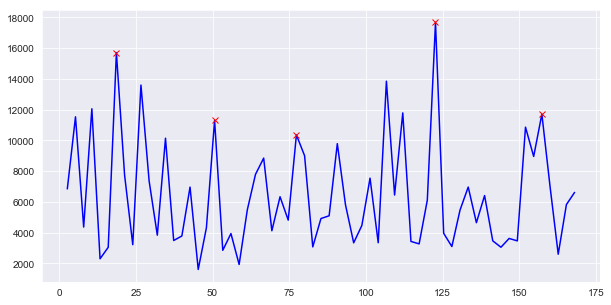

In [73]:
fig = plt.figure(figsize=(10,5))
plt.plot(x, y, 'b')
plt.plot(f_values[peaks_ind], fft_values[peaks_ind], 'x', color='r')

Definiamo una funzione per estrapolare i primi n picchi con relative frequenze e ampiezze.

In [74]:
def get_first_n_peaks(x, y, n_peaks):
    
    """
    seleziona i primi n picchi del segnale trasformato,
    restituisce le frequenze dei picchi selezionati
    e le corrispondenti ampiezze
    
    parametri:
    ----------
    x : 1D array contenente le frequenze dei picchi
    y : 1D array contentente i valori di ampiezza dei picchi
    n_peaks: numero di picchi da selezionare
    
    return:
    -------
    1D array contenente i valori delle frequenze di picco scelte
    1D array contenente i valori delle corrispondenti ampiezze
    
    """
    
    if len(x) >= n_peaks:
        
        return x[:n_peaks], y[:n_peaks]
    
    else:
        missing_n_peaks = n_peaks - len(x)
        
        peaks_x = (np.append(x[:n_peaks], np.zeros(missing_n_peaks))).astype(int)
        peaks_y = (np.append(y[:n_peaks], np.zeros(missing_n_peaks))).astype(int)
        
        return peaks_x, peaks_y

In [75]:
peaks_x, peaks_y = get_first_n_peaks(f_values[peaks_ind], fft_values[peaks_ind], n_peaks=5)

In [76]:
peaks_x, peaks_y

(array([ 18.66433362,  50.66033412,  77.32366787, 122.65133525,
        157.31366912]),
 array([15704.1243613 , 11306.20503708, 10353.01157452, 17674.8931858 ,
        11701.15198076]))

Definiamo delle funzioni che racchiudano gli step precedenti.

In [77]:
def import_data(data_path, file_name, res=True, delta_ms='3ms'):
    
    """
    importa i dati in formato .csv in un DataFrame pandas,
    aggiunge la colonna con il modulo del segnale complessivo, 
    consente di ricampionare il segnale, indicando il timing tra
    campioni consecutivi di segnale
    
    parametri :
    -----------
    data_path : percorso dei file csv dei singoli segnali
    file_name : nome del file csv del singolo segnale
    res : boolean, default True
        effettua il resampling del segnale
    delta_ms : str, default '3ms'
        definisce l'intevallo in ms per il resampling
        
    return :
    --------
    df : pandas DataFrame del segnale importato
    
    """
    
    file_path = data_path + file_name
    df = pd.read_csv(file_path, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    return df

In [78]:
def preprocess_signal_FFT(df, var, start_idx, end_idx):
    
    """
    calcola la Fast Fourier Transform del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
           
    # applica la FFT al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(df[var])
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
    return f_values, fft_values

In [79]:
def plot_preprocessed_signal_FFT(x, y, color, var="", label=""):
    
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, f_values
    y : 1D array, fft_values
    """
    
    x, y = x[1:], y[1:]
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel('Frequency [Hz]', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.title("FFT of the signal " + var + ", " + label, fontsize=16)
    plt.show()

In [80]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [81]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

In [82]:
df = import_data(data_path, file_name, delta_ms='3ms')

In [83]:
df.head()

x        y       z       i             m
date_time                                                             
2018-09-20 15:33:50.586 -1644.0  14448.0    72.0  2127.0  14541.410661
2018-09-20 15:33:50.589 -1552.0  18752.0 -3692.0  2110.0  19174.907353
2018-09-20 15:33:50.592   630.0  17116.0 -3040.0  2120.5  17544.216335
2018-09-20 15:33:50.595  2812.0  15480.0 -2388.0  2131.0  15913.525317
2018-09-20 15:33:50.598 -1808.0  16280.0   972.0  2138.0  16408.901487

In [84]:
f_values, fft_values = preprocess_signal_FFT(df, 'x', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

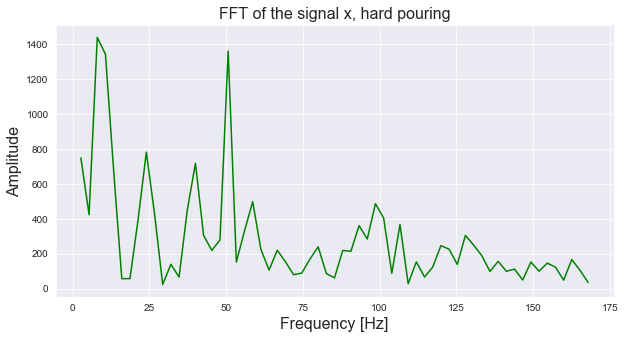

In [85]:
plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='hard pouring')

<Figure size 432x288 with 0 Axes>

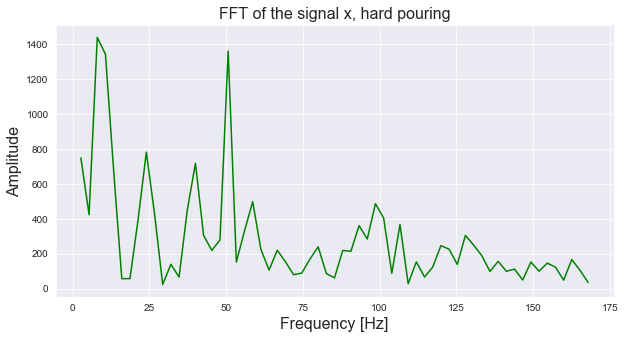

In [86]:
# più concisamente
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='x', start_idx=0, end_idx=128), var='x', color='g', label='hard pouring')

Il segnale, rappresentato nello spazio delle frequenze, appare molto irregolare per via del rumore presente. Possiamo utilizzarlo tal quale, per non perdere informazione, o applicare dei filtri per renderlo più regolare con il rischio di perdere informazione importante ai fini della caratterizzazione e classificazione del segnale stesso.

----

Valutiamo se i dati di corrente contengono informazione utile a discriminare le varie modalità di funzionamento.

In [87]:
all_files

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\1_coffee-pouring-empty-20180920--15_30_41.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\2_coffee-pouring-normal-20180920--15_24_10.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\3_coffee-pouring-hard-20180920--15_33_50.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\4_coffee-moving-20180920--15_35_14.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\5_coffee-standby-20180920--15_17_26.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\6_ coffee-steam-20180920--15_37_37.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [88]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [89]:
file_name = "1_coffee-pouring-empty-20180920--15_30_41.csv"

In [90]:
df_norm = import_data(data_path, file_name)

In [91]:
df_norm.head()

x             y       z            i  \
date_time                                                                 
2018-09-20 15:30:41.730 -5632.000000  13304.000000  5184.0  2142.000000   
2018-09-20 15:30:41.733 -3633.333333  13857.333333  1820.0  2137.666667   
2018-09-20 15:30:41.736 -1634.666667  14410.666667 -1544.0  2133.333333   
2018-09-20 15:30:41.739   364.000000  14964.000000 -4908.0  2129.000000   
2018-09-20 15:30:41.742  5018.000000  15772.000000 -6848.0  2117.500000   

                                    m  
date_time                              
2018-09-20 15:30:41.730  15348.931429  
2018-09-20 15:30:41.733  15483.464863  
2018-09-20 15:30:41.736  15617.998298  
2018-09-20 15:30:41.739  15752.531733  
2018-09-20 15:30:41.742  18431.749370

In [92]:
f_values, fft_values = preprocess_signal_FFT(df_norm, var='i', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

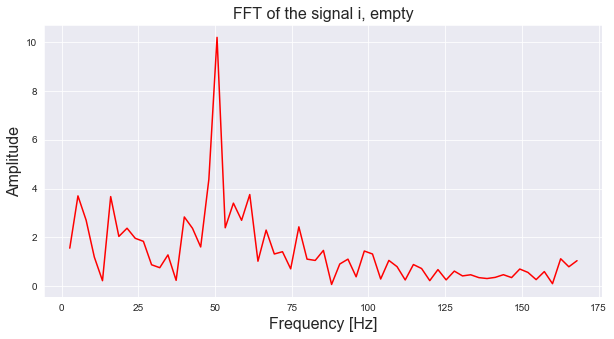

In [93]:
plot_preprocessed_signal_FFT(f_values, fft_values, var='i', color='r', label='empty')

In [94]:
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"

<Figure size 432x288 with 0 Axes>

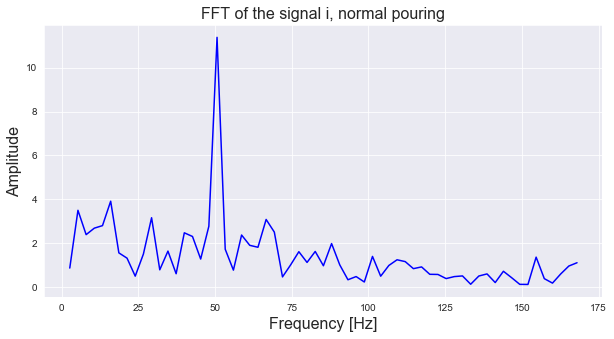

In [95]:
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='i', start_idx=0, end_idx=128), var='i', color='b', label='normal pouring')

In [96]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

<Figure size 432x288 with 0 Axes>

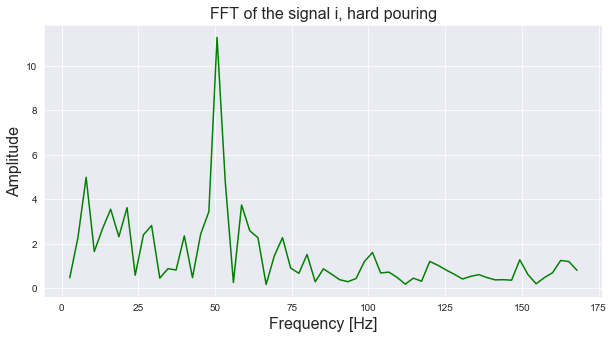

In [97]:
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='i', start_idx=0, end_idx=128), var='i', color='g', label='hard pouring')

Confrontiamo le trasformate in un'unica figura.

In [98]:
f_values_E, fft_values_E = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "1_coffee-pouring-empty-20180920--15_30_41.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)
f_values_N, fft_values_N = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)
f_values_H, fft_values_H = preprocess_signal_FFT(import_data(data_path,
                                  file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv", delta_ms='3ms'), 
                      var='i', start_idx=0, end_idx=128)

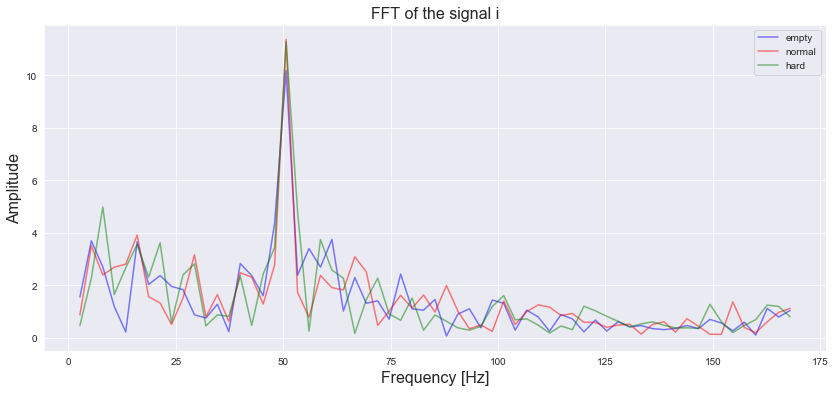

In [99]:
plt.figure(figsize=(14,6))
plt.plot(f_values_E[1:], fft_values_E[1:], linestyle='-', color="b", alpha=0.5, label='empty')
plt.plot(f_values_N[1:], fft_values_N[1:], linestyle='-', color="r", alpha=0.5, label='normal')
plt.plot(f_values_H[1:], fft_values_H[1:], linestyle='-', color="g", alpha=0.5, label='hard')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal i", fontsize=16)
plt.legend()
plt.show()

Utilizziamo plotly per una visualizzazione più interattiva.

In [100]:
import cufflinks as cf

In [101]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [102]:
init_notebook_mode(connected=True)

In [103]:
cf.go_offline()

In [104]:
len(fft_values_E)

64

In [105]:
df_e = import_data(data_path, file_name="1_coffee-pouring-empty-20180920--15_30_41.csv")

In [106]:
N, delta_time_sec, T, fs = get_signal_properties(df_e, start_time_idx=0, end_time_idx=128)

In [107]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [108]:
df_n = import_data(data_path, file_name="2_coffee-pouring-normal-20180920--15_24_10.csv")

In [109]:
N, delta_time_sec, T, fs = get_signal_properties(df_n, start_time_idx=0, end_time_idx=128)

In [110]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [111]:
df_h = import_data(data_path, file_name="3_coffee-pouring-hard-20180920--15_33_50.csv")

In [112]:
N, delta_time_sec, T, fs = get_signal_properties(df_n, start_time_idx=0, end_time_idx=128)

In [113]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [114]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [115]:
fft_dict = {"f_values":f_values, "fft Empty":fft_values_E, "fft Normal":fft_values_N, "fft Hard":fft_values_H}

In [116]:
df_i = pd.DataFrame(data = fft_dict)

In [117]:
df_i.head()

f_values    fft Empty   fft Normal     fft Hard
0   0.000000  4252.789062  4250.875000  4251.429688
1   2.666333     1.560022     0.881689     0.475347
2   5.332667     3.699558     3.507449     2.280724
3   7.999000     2.703775     2.401362     4.987778
4  10.665333     1.196965     2.695938     1.653822

In [118]:
df_i.drop(axis=0, index=0, inplace=True)

In [119]:
df_i.head()

f_values  fft Empty  fft Normal  fft Hard
1   2.666333   1.560022    0.881689  0.475347
2   5.332667   3.699558    3.507449  2.280724
3   7.999000   2.703775    2.401362  4.987778
4  10.665333   1.196965    2.695938  1.653822
5  13.331667   0.228697    2.810739  2.676008

In [120]:
df_i.set_index('f_values', inplace=True)

In [121]:
df_i.iplot()

Visualizzando le FFT dei dati di corrente per diverse modalità operative, appare evidente che le classi sono pressocché indistinguibili. Per cui concentreremo la nostra attenzione sui dati catturati dall'accelerometro.

### 2.1.1. Signal filtering

#### ======= You can skip the next cells if you don't want to remove the noise from the data =======

Proviamo ad applicare un filtro passa-basso per rendere più smooth il segnale.

In [122]:
# crea un filtro di Butterworth di ordine 1 e cutoff a 0.2 Hz
Nf  = 1    # Filter order
Wn = 0.2 # Cutoff frequency
B, A = butter(Nf, Wn, output='ba')

In [123]:
# applica il filtro
df_res_filt_x = filtfilt(B, A, df_res['x'])

In [124]:
df_res['x_filt'] = df_res_filt_x

In [125]:
df_res.head()

date_time            x             y       z            i  \
0 2018-09-20 15:24:10.452 -7464.000000  16632.000000  2060.0  2111.000000   
1 2018-09-20 15:24:10.455 -4024.000000  17066.000000  1708.0  2117.500000   
2 2018-09-20 15:24:10.458  -584.000000  17500.000000  1356.0  2124.000000   
3 2018-09-20 15:24:10.461  -205.333333  15913.333333   284.0  2130.666667   
4 2018-09-20 15:24:10.464   173.333333  14326.666667  -788.0  2137.333333   

        x_filt  
0 -7462.909731  
1 -4886.601198  
2 -2717.557707  
3 -1194.502136  
4  -138.468722

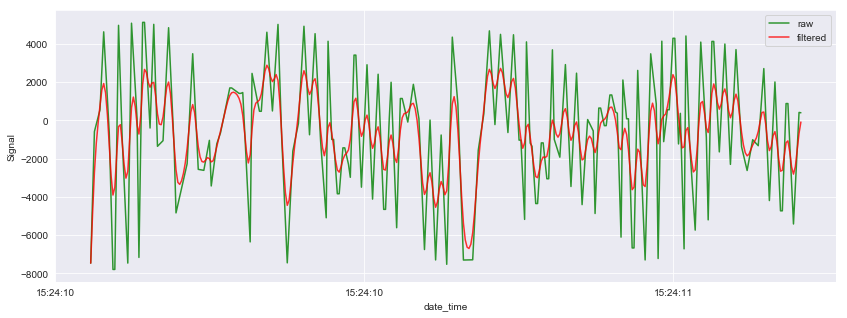

In [126]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df_res[0:384], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filt', data=df_res[0:384], color='r', alpha=0.8, label='filtered')
plt.ylabel('Signal')
plt.legend()

In [127]:
f_values, fft_values = preprocess_signal_FFT(df_res, 'x', start_idx=0, end_idx=128)

In [128]:
f_values, fft_values_filt = preprocess_signal_FFT(df_res, 'x_filt', start_idx=0, end_idx=128)

In [129]:
#plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='normal pouring')
#plot_preprocessed_signal_FFT(f_values, fft_values_filt, var='x_filt', color='r', label='normal pouring')

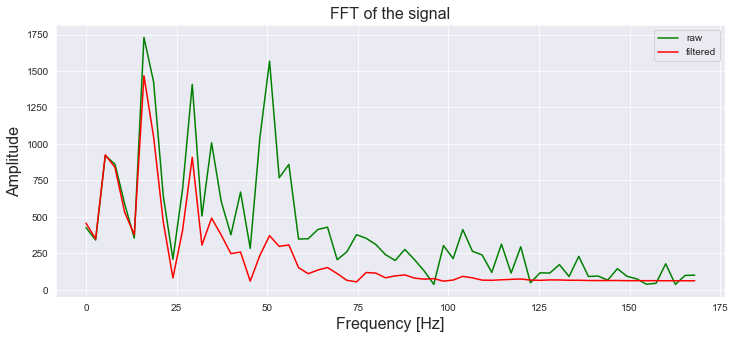

In [130]:
plt.figure(figsize=(12,5))
plt.plot(f_values, fft_values, linestyle='-', color='g', label='raw')
plt.plot(f_values, fft_values_filt, linestyle='-', color='r', label='filtered')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.legend()
plt.show()

In [131]:
def filter_signal(df, Nf, Wn, var_to_filter):
    
    """
    crea un filtro di Butterworth di ordine Nf e cutoff Wn [Hz]
    
    parametri:
    ----------
    df : pandas DataFrame contenente il segnale
    Nf  : ordine del filtro
    Wn : frequenza di cutoff
    var_to_filter : variabile a cui applicare il filtro
    
    return:
    -------
    df : pandas DataFrame con segnale filtrato
    
    """
    
    B, A = butter(Nf, Wn, output='ba')
    df[var_to_filter + '_filtered'] = filtfilt(B, A, df[var_to_filter])
    
    return df

In [132]:
df = import_data(data_path, file_name)

In [133]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [134]:
df.head()

x        y       z       i             m  \
date_time                                                                
2018-09-20 15:33:50.586 -1644.0  14448.0    72.0  2127.0  14541.410661   
2018-09-20 15:33:50.589 -1552.0  18752.0 -3692.0  2110.0  19174.907353   
2018-09-20 15:33:50.592   630.0  17116.0 -3040.0  2120.5  17544.216335   
2018-09-20 15:33:50.595  2812.0  15480.0 -2388.0  2131.0  15913.525317   
2018-09-20 15:33:50.598 -1808.0  16280.0   972.0  2138.0  16408.901487   

                          x_filtered  
date_time                             
2018-09-20 15:33:50.586 -1635.146587  
2018-09-20 15:33:50.589  -986.352549  
2018-09-20 15:33:50.592  -317.187048  
2018-09-20 15:33:50.595   -95.222609  
2018-09-20 15:33:50.598  -442.995301

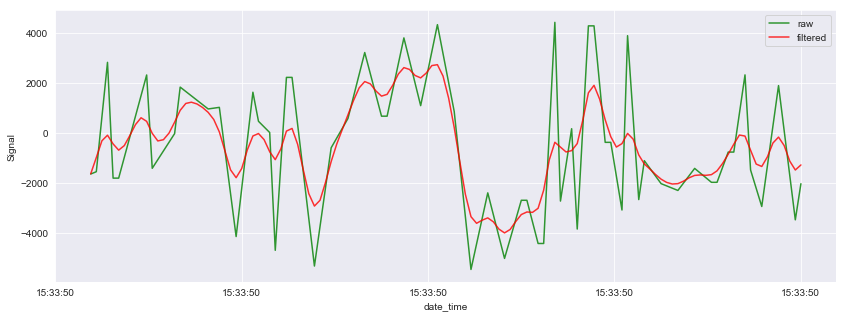

In [135]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df.reset_index()[0:128], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filtered', data=df.reset_index()[0:128], color='r', alpha=0.8, label='filtered')
plt.ylabel('Signal')
plt.legend()

#### ==============

Decidiamo una funzione di plot generale, valida per ogni tipo di processing.

In [136]:
def plot_preprocessed_signal(x, y, process, color, var="", label=""):
    
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, x_values
    y : 1D array, y_values
    
    parametri per la formattazione del plot:
    ----------------------------------------
    process : processo di trasformazione
    color : colore della funzione visualizzata
    label : tipo di modalità di funzionamento
    
    """
    
    xlabels = {0:'Frequency [Hz]', 1:'Frequency [Hz]', 2:'Time delay [s]'}
    ylabels = {0:'Amplitude', 1:'PSD [V**2 / Hz]', 2:'Autocorrelation amplitude'}
    titles = {0:'FFT', 1:'PSD', 2:'Autocorrelation'}
    processing_types = {'FFT':0, 'PSD':1, 'aCorr':2}
    
    x, y = x[1:], y[1:]
    
    i = processing_types[process]
    xlabel = xlabels[i]
    ylabel = ylabels[i]
    title = titles[i]
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))        
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+" of the signal " + var + ", " + label, fontsize=16)
    plt.show()

Calcoliamo la FFT per **tutti i file** e plottiamola

In [137]:
files_list = os.listdir(data_path)

In [138]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [139]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

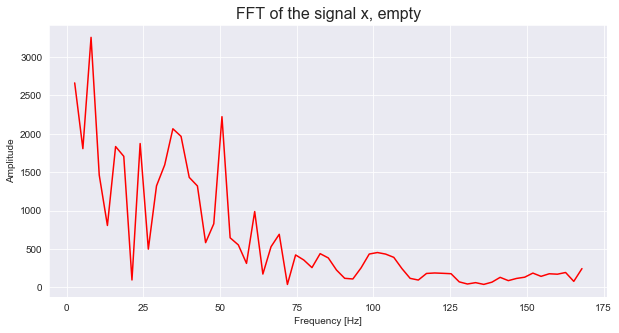

<Figure size 432x288 with 0 Axes>

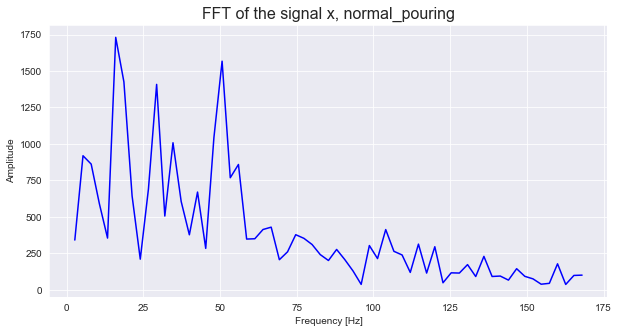

<Figure size 432x288 with 0 Axes>

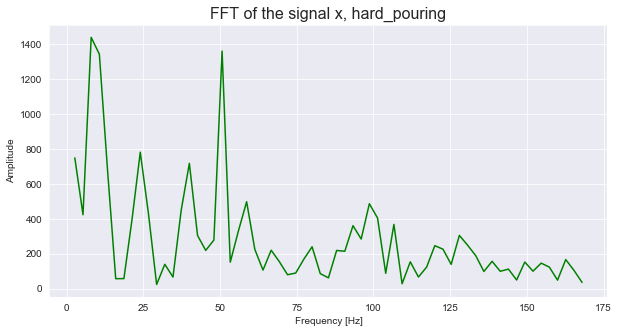

<Figure size 432x288 with 0 Axes>

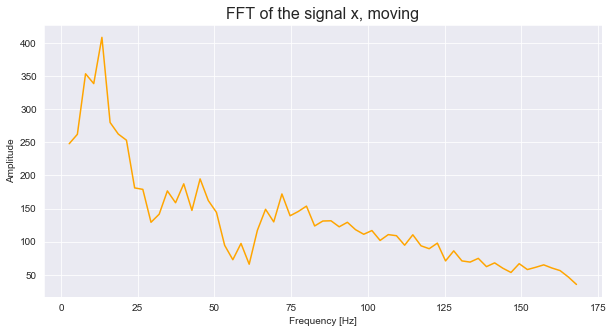

<Figure size 432x288 with 0 Axes>

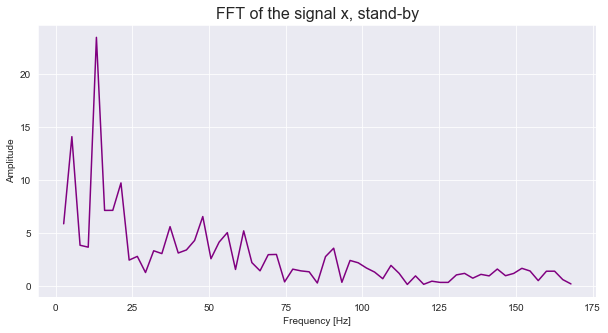

<Figure size 432x288 with 0 Axes>

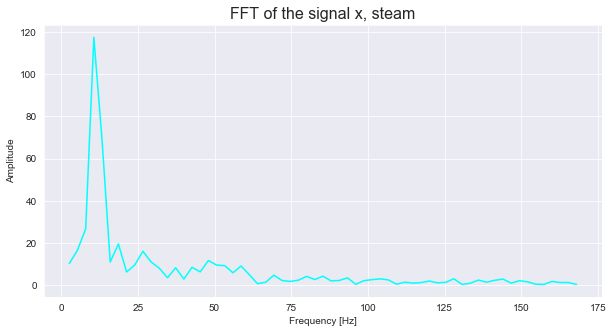

<Figure size 432x288 with 0 Axes>

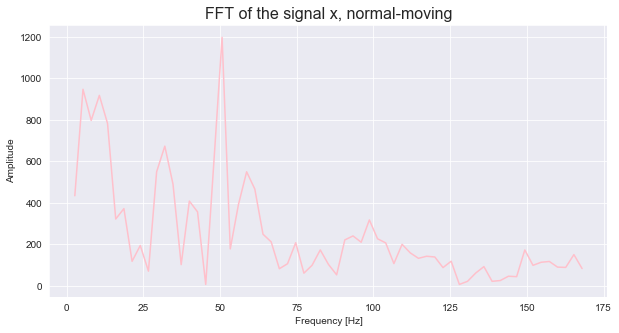

In [140]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro
        #df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')
        #x, y = preprocess_signal_FFT(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_FFT(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='FFT', color=colors[c], label=labels[c])

### 2.2. Pre-processing PSD

Un altro modo per analizzare lo spettro delle frequenze consiste nel calcolare la densità spettrale di potenza PSD. Calcoliamo la PSD per il **singolo file.**

In [141]:
def preprocess_signal_PSD(df, var, start_idx, end_idx):
    
    """
    calcola la Power Spectral Density PSD del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """

    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    # applica la PSD al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    samples = end_idx-start_idx
    f_values, psd_values = welch(df[var], fs=f, nperseg=samples)
       
    return f_values, psd_values

In [142]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [143]:
file_name = '3_coffee-pouring-hard-20180920--15_33_50.csv'

In [144]:
df = import_data(data_path, file_name)

In [145]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [146]:
f_values, psd_values = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)

In [147]:
f_values.size, psd_values.size

(65, 65)

<Figure size 432x288 with 0 Axes>

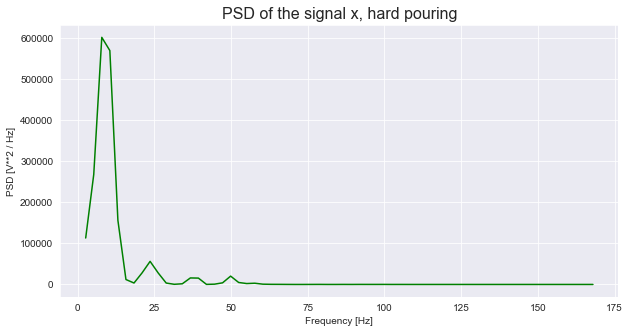

In [148]:
plot_preprocessed_signal(f_values, psd_values, process='PSD', var='x', color='g', label='hard pouring')

In [149]:
psd_threshold = 0.01*(np.max(psd_values) - np.min(psd_values))

In [150]:
# la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(psd_values, threshold=psd_threshold, distance=5) 

In [151]:
peaks_ind

array([ 3,  9, 19], dtype=int64)

In [152]:
psd_peaks = psd_values[peaks_ind]

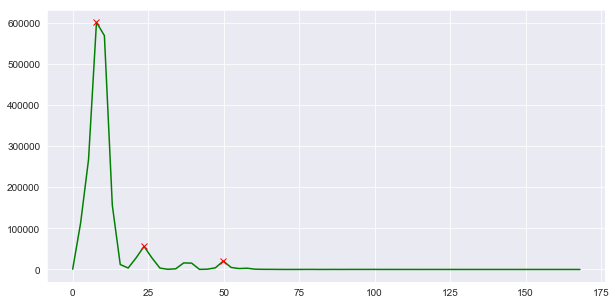

In [153]:
fig = plt.figure(figsize=(10,5))
plt.plot(f_values, psd_values, 'g')
plt.plot(f_values[peaks_ind], psd_values[peaks_ind], 'x', color='r')

Calcoliamo la PSD per **tutti i file** e plottiamola.

In [154]:
files_list = os.listdir(data_path)
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

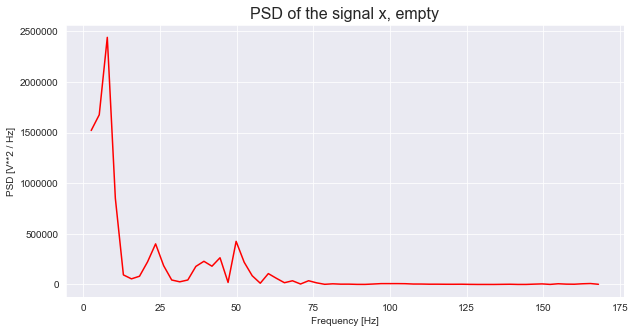

<Figure size 432x288 with 0 Axes>

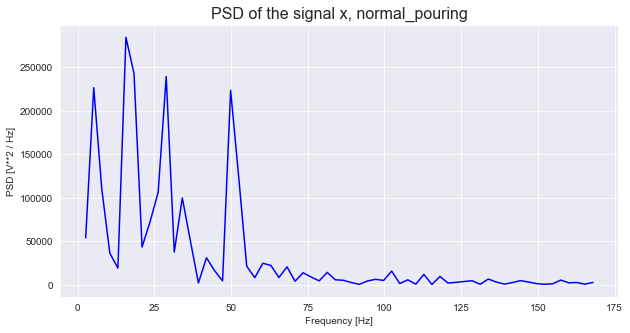

<Figure size 432x288 with 0 Axes>

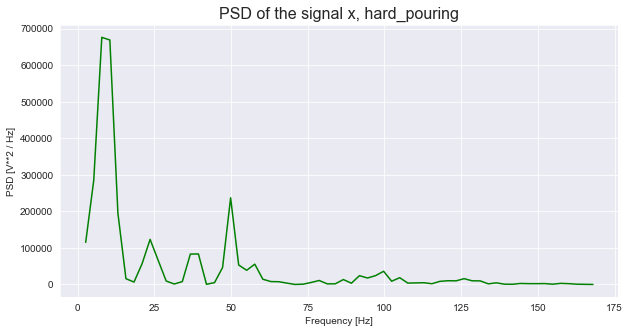

<Figure size 432x288 with 0 Axes>

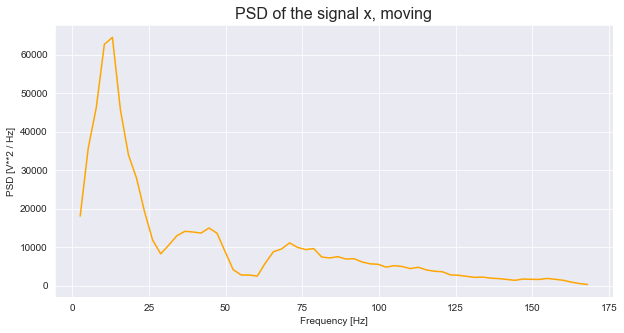

<Figure size 432x288 with 0 Axes>

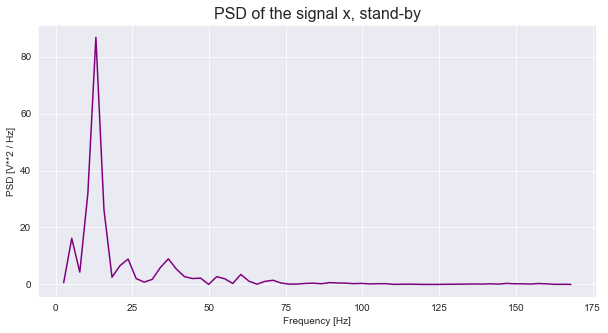

<Figure size 432x288 with 0 Axes>

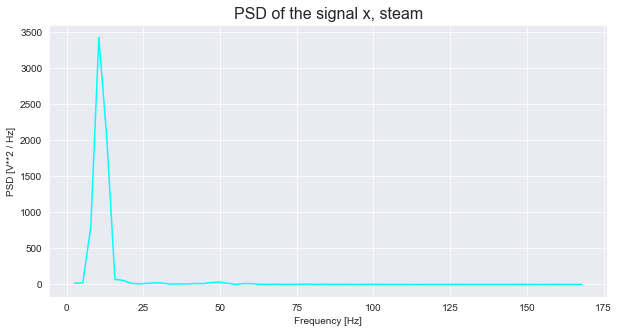

<Figure size 432x288 with 0 Axes>

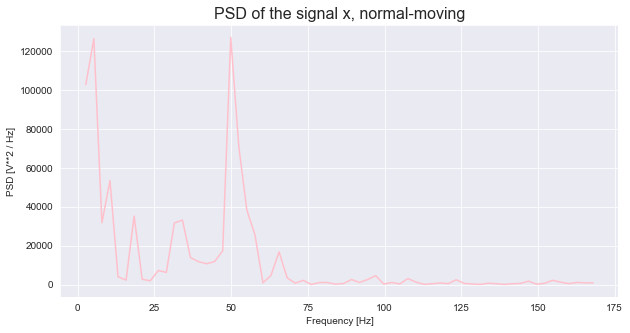

In [155]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro        
        #df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
        #x, y = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_PSD(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='PSD', color=colors[c], label=labels[c])

### 2.3. Pre-processing autocorrelation index

Calcola quanto il segnale è correlato con una versione "ritardata" del segnale stesso. Calcoliamo l'autocorrelation index per il **singolo file.**

In [156]:
def preprocess_signal_autocorr(df, var, start_idx, end_idx):
    
    """
    calcola l'indice di autocorrelazione del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    delta_time_sec = (df['date_time'][end_idx - 1] - df['date_time'][start_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    
    # calcola l'autocorrelation index
    result = np.correlate(df[var], df[var], mode='full')
    autocorr_values = result[result.size//2:]
    t_values = np.array([T*jj for jj in range(0, N)])
    
    return  t_values, autocorr_values

In [157]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [158]:
df = import_data(data_path, file_name)

In [159]:
df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')

In [160]:
t_values, autocorr_values = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

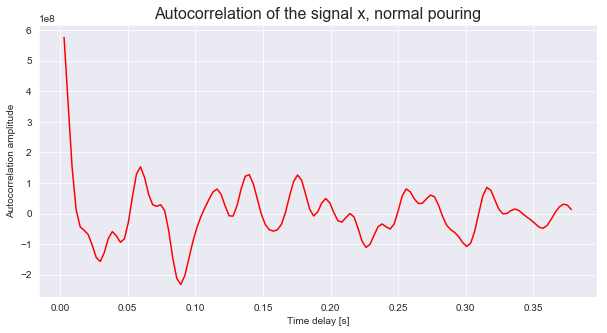

In [161]:
plot_preprocessed_signal(t_values, autocorr_values, process='aCorr', var='x', color='r', label='normal pouring')

In [162]:
peaks_ind, _ = find_peaks(autocorr_values, threshold=None, distance=10)

In [163]:
peaks_ind

array([ 20,  47,  59,  72,  86, 106, 125], dtype=int64)

In [164]:
t_values[peaks_ind]

array([0.05953125, 0.13989844, 0.17561719, 0.2143125 , 0.25598437,
       0.31551563, 0.37207031])

In [165]:
autocorr_peaks = autocorr_values[peaks_ind]
autocorr_peaks

array([ 1.52455740e+08,  1.27049969e+08,  1.25881985e+08, -1.89856416e+05,
        8.05953017e+07,  8.52495717e+07,  3.04617134e+07])

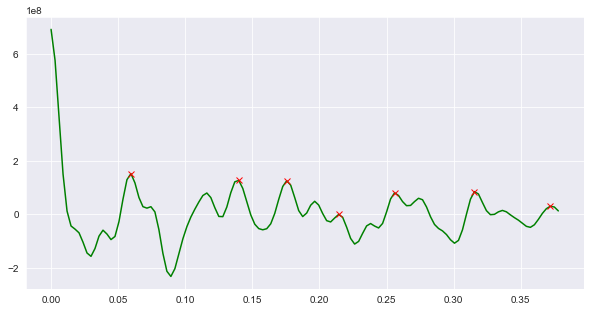

In [166]:
fig = plt.figure(figsize=(10,5))
plt.plot(t_values, autocorr_values, 'g')
plt.plot(t_values[peaks_ind], autocorr_values[peaks_ind], 'x', color='r')

In [167]:
# seleziona il numero di picchi desiderato
peak_x, peak_y = get_first_n_peaks(t_values[peaks_ind], autocorr_values[peaks_ind], n_peaks=5)

In [168]:
peak_x, peak_y

(array([0.05953125, 0.13989844, 0.17561719, 0.2143125 , 0.25598437]),
 array([ 1.52455740e+08,  1.27049969e+08,  1.25881985e+08, -1.89856416e+05,
         8.05953017e+07]))

Calcoliamo l'autocorrelation index per **tutti i file.**

In [169]:
files_list = os.listdir(data_path)

In [170]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

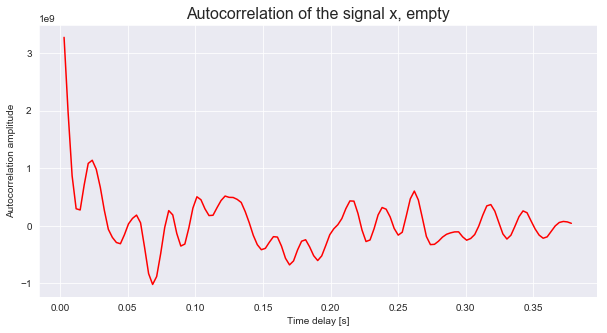

<Figure size 432x288 with 0 Axes>

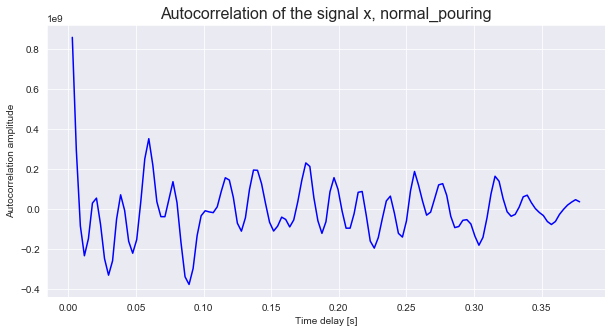

<Figure size 432x288 with 0 Axes>

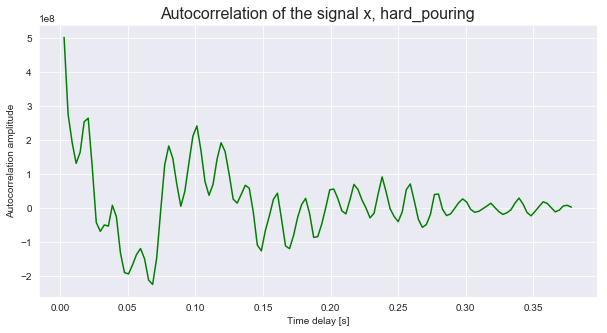

<Figure size 432x288 with 0 Axes>

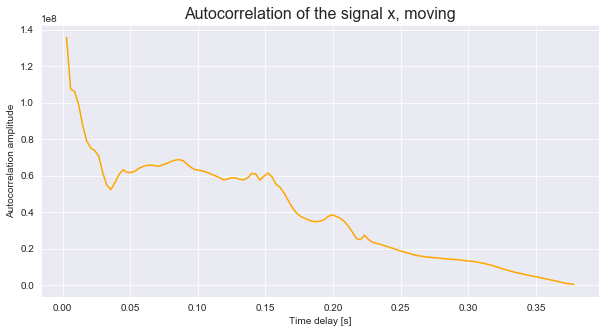

<Figure size 432x288 with 0 Axes>

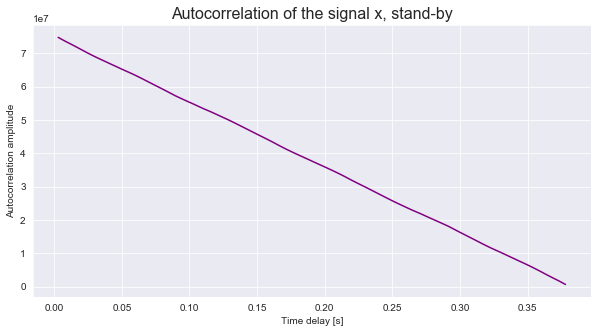

<Figure size 432x288 with 0 Axes>

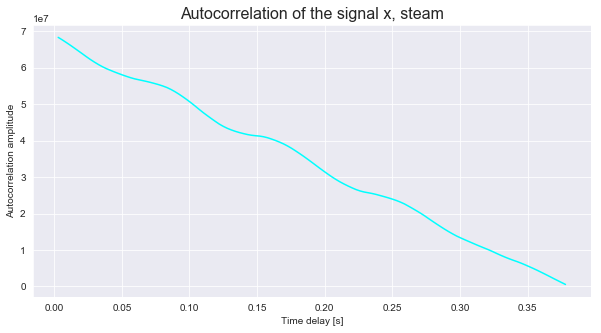

<Figure size 432x288 with 0 Axes>

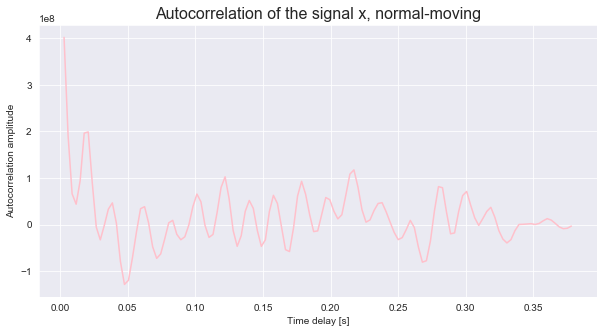

In [171]:
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
        
        file_name = f
        c = file_name[0]
        df = import_data(data_path, file_name, delta_ms='3ms')
        # decommmenta le due righe successiva e commenta la terza per applicare il filtro 
        #df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
        #x, y = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)
        x, y = preprocess_signal_autocorr(df, var='x', start_idx=0, end_idx=128)
        plot_preprocessed_signal(x, y, var='x', process='aCorr', color=colors[c], label=labels[c])

Condensiamo il preprocessing del segnale in un'unica funzione

In [172]:
def preprocess_signal(df, var, process, start_idx, end_idx):
    
    """
    effettua il preprocessing del segnale scelto, in base al tipo di processo
    passato come parametro, riferito alla finestra temporale selezionata

    parametri:
    ----------
    
    df : pandas DataFrame, serie storica di una o più variabili
    var : str, variabile da processare
    process : str, tipo di trasformazione
            {'FFT': Fast Fourier Transform,
             'PSD': Power Spectral Density,
             'aCorr': Autocorrelation Index}
    start_idx : int, indice dell'istante iniziale
    end_idx : int, indice dell'istante finale
    
    return:
    -------
    x : x del segnale processato (frequenza o intervallo temporale)
    y : y del del segnale processato (ampiezza o indice di autocorrelazione)
    
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    f = 1/T
    
    if process == 'FFT':        
        # applica la FFT al segnale
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = fft(df[var])
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
        return f_values, fft_values
    
    elif process == 'PSD':
        # applica la PSD al segnale
        samples = end_idx-start_idx
        f_values, psd_values = welch(df[var], fs=f, nperseg=samples)

        return f_values, psd_values
    
    elif process == 'aCorr':
        # calcola l'autocorrelation index
        result = np.correlate(df[var], df[var], mode='full')
        autocorr_values = result[result.size//2:]
        t_values = np.array([T*jj for jj in range(0, N)])
    
        return  t_values, autocorr_values
    
    else:
        print("Process is not valid!\n")
        print("Processes available are: 'FFT', 'PSD', 'aCorr'. Enter a valid process.")
        return False, False

In [173]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [174]:
df = import_data(data_path, file_name, res= True, delta_ms='3ms')

In [175]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [176]:
x, y = preprocess_signal(df, var='x_filtered', process='FFT',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

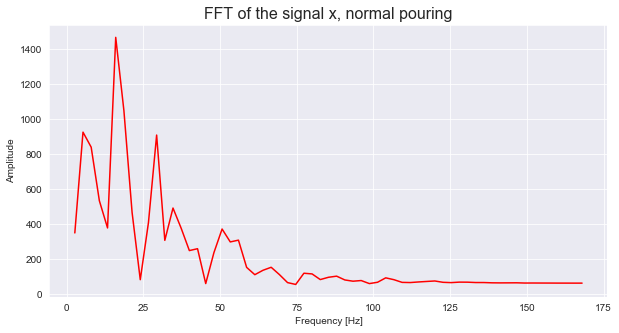

In [177]:
plot_preprocessed_signal(x, y, process='FFT', color='r', var='x', label='normal pouring')

In [178]:
x, y = preprocess_signal(df, var='x_filtered', process='PSD',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

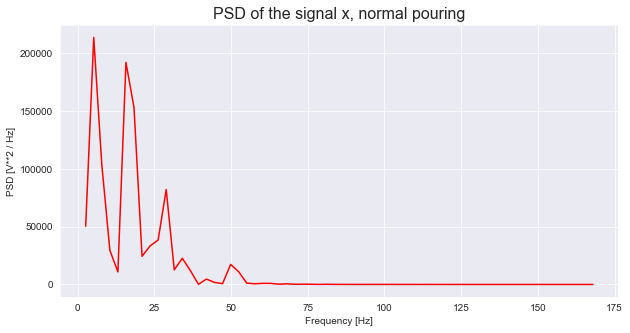

In [179]:
plot_preprocessed_signal(x, y, process='PSD', color='r', var='x', label='normal pouring')

In [180]:
x, y = preprocess_signal(df, var='x_filtered', process='aCorr', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

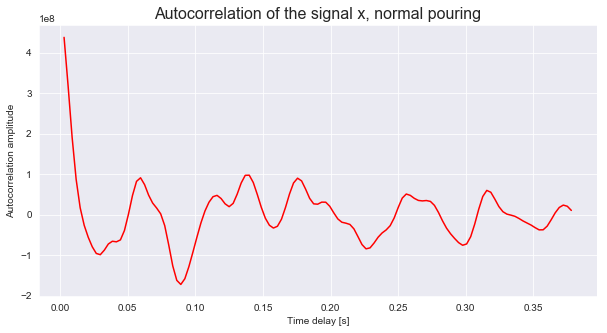

In [181]:
plot_preprocessed_signal(x, y, process='aCorr', color='r', var='x', label='normal pouring')

In [182]:
x, y = preprocess_signal(df, var='x_filtered', process='FT',start_idx=0, end_idx=128)

Process is not valid!

Processes available are: 'FFT', 'PSD', 'aCorr'. Enter a valid process.


## 3. Data preparation for modelling

I seguenti step sono finalizzati a preaparare i dati per la parte di modelling a partire dai singoli file csv contenenti il segnale campionato per le differenti modalità di funzionamento che si intende classificare.

In sintesi si procede a:
- Bilanciare le classi per ottenere segnali di pari dimensione per ogni classe
- Importare i singoli segnali (con possibilità di ricampionamento) e annotarli (labelling)
- Suddividere ciascun segnale in due gruppi di buffer consecutivi, uno per il training e l'altro per il test, per ciascuna classe e per ciascuna variabile da analizzare
- Riorganizzare ciascun segnale in modo da ottenere una struttura in cui ad ogni record corrisponde un buffer costituito da un certo numero di campioni, con la possibilità di sovrapposizione tra buffer consecutivi
- Aggregare i dati in un'unica struttura contenente tutte le classi, per ciascuna variabile
- Estrarre delle feature da ogni buffer, basate sulle trasformazioni precedentemente definite
- Creare due dataset (uno per il training e uno per il test) contenenti tutti i segnali con le relative feature estratte da ogni buffer

In [183]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [184]:
files_list = os.listdir(data_path)

In [185]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [187]:
files_list.sort()

nsamples_lst = []

for f in files_list:
    
    if f[0].isdigit() and int(f[0]) in range(1, 6):
        
        file_name = f
        c = file_name[0]
        df = pd.read_csv(data_path + f, delimiter=',', header=None)
        
        nsamples_lst.append(df.shape[0])
        
        print("Il file {0} contiene {1} sample".format(f, df.shape[0]))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv contiene 10230 sample
Il file 2_coffee-pouring-normal-20180920--15_24_10.csv contiene 25575 sample
Il file 3_coffee-pouring-hard-20180920--15_33_50.csv contiene 10230 sample
Il file 4_coffee-moving-20180920--15_35_14.csv contiene 10230 sample
Il file 5_coffee-standby-20180920--15_17_26.csv contiene 51150 sample


Per avere lo stesso numero di sample per ogni classe, prendiamo la classe meno numerosa e selezioniamo lo stesso numero di campioni per tutte le restanti classi. Selezioniamo poi una parte di questi esempi per il training e l'altro per il testing, scegliendo uno split ratio.

In [188]:
less_num_class = min(nsamples_lst)

print("Il file {0} con {1} sample rappresenta la classe meno numerosa".format(
    files_list[nsamples_lst.index(less_num_class)], less_num_class))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv con 10230 sample rappresenta la classe meno numerosa


Questa funzione genara un dataframe con tutte le variabili.

In [189]:
def import_data(data_path, file_name, res=True, delta_ms='3ms'):
    
    """
    importa i dati in formato .csv in un DataFrame pandas,
    aggiunge la colonna con il modulo del segnale complessivo, 
    consente di ricampionare il segnale, indicando il timing tra
    campioni consecutivi di segnale
    
    parametri :
    -----------
    data_path : percorso dei file csv dei singoli segnali
    file_name : nome del file csv del singolo segnale
    res : boolean, default True
        effettua il resampling del segnale
    delta_ms : str, default '3ms'
        definisce l'intevallo in ms per il resampling
        
    return :
    --------
    df : pandas DataFrame del segnale importato
    
    """
    
    file_path = data_path + file_name
    df = pd.read_csv(file_path, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    return df

In [190]:
def prepare_data(file_name, end_index, split_ratio):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file,  lo divide
    in due df separati secondo lo split_ratio e li salva in due file .csv,
    uno per il training e l'altro per il test in due directory differenti
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    end_index : int, indice dell'ultima riga (campione)
                del segnale originario
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)    
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, encoding='utf-8')

In [191]:
def prepare_res_data(file_name, split_ratio, res=True, delta_ms='3ms'):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file,  lo divide
    in due df separati secondo lo split_ratio e li salva in due file .csv,
    uno per il training e l'altro per il test in due directory differenti.
    Consente di ricampionare il segnale, indicando il timing tra campioni
    consecutivi di segnale
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)
    res : boolean, default True
          effettua il resampling del segnale
    delta_ms : str, default '3ms'
               definisce l'intevallo in ms per il resampling
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    end_index = df.shape[0] - 1
    split_index = int(end_index * split_ratio)
    
    df = df.reset_index()
    df = df[0:end_index]

    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, float_format='%.3f', encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path + "INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, float_format='%.3f', encoding='utf-8')

In [192]:
#data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [186]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_res_data(file_name, split_ratio=0.7)

In [187]:
# per tutti i file della cartella
files_list.sort()

for f in files_list:
    
    if f[0].isdigit():
    
        prepare_res_data(f, split_ratio=0.7)

Questa funzione genera un diverso dataset per ciascuna variabile.

In [193]:
def prepare_data_split_variables(file_name, end_index, split_ratio, var_to_store):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file, lo divide
    in due df separati secondo lo split_ratio, selezionando una variabile,
    e li salva in due file .csv, uno per il training e l'altro per il test
    in due directory differenti
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    end_index : int, indice dell'ultima riga (campione)
                del segnale originario
    split_ratio : float in [0,1], ratio di separazione
                del segnale in train e test
                (ex.: split_ratio=0.7 --> 70% del segnale in train set
                                          30% del segnale in test set)
    var_to_store : str, variabile da processare e salvare nel file csv
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['label'] = label
        
    df = df[0:end_index]

    df_train = df[0:split_index]
    #df_train_label = df_train['label'].values
    df_train = df_train.drop('label', axis=1)

    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f', encoding='utf-8')
    df_test = df[split_index:]
    #df_test_label = df_test['label'].values
    df_test = df_test.drop('label', axis=1)


    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f', encoding='utf-8')

In [ ]:
def prepare_all_data_split_variables(file_name, var_to_store, res=True, delta_ms='3ms'):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi e il formato
    delle colonne, aggiunge la label in base al nome del file, seleziona
    una variabile, e lo salva in un file csv. Consente di ricampionare il
    segnale, indicando il timing tra campioni consecutivi di segnale
    
    prametri :
    ----------
    file_name : str, nome del file csv da importare
    var_to_store : str, variabile da processare e salvare nel file csv
    res : boolean, default True
          effettua il resampling del segnale
    delta_ms : str, default '3ms'
               definisce l'intevallo in ms per il resampling
    
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    
    if res:
        
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    df = df.reset_index()
    df['label'] = label

    df.to_csv(data_path + "INPUT\\" + label + "_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], float_format='%.3f',
                    encoding='utf-8')

In [199]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_all_data_split_variables(file_name, var_to_store='x', res=True)

In [201]:
# per tutti i file della cartella
cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
files_list.sort()

for f in files_list:
    
    if f[0].isdigit() and int(f[0]) in range(1, 6):
            
        for i in range(1,4):

            prepare_all_data_split_variables(f, var_to_store=cols[i])

### 3.1. Data reshape

Riorganizziamo i dati secondo una struttura in cui ad ogni riga corrisponde un buffer del segnale campionato e per colonne i valori assunti da ciascun campione per ogni variabile. Tutti i segnali corrispondenti alle modalità di funzionamento saranno concatenati. Otterremo infine tre file csv, uno per ogni variabile.

In [202]:
def get_input_signals(file_name, nsamples):
    
    """
    prende il segnale campionato e lo divide in un certo numero
    di parti (buffer) sulla base del numero di campioni selezionati [nsamples],
    generando un df pandas di dimensioni (num buffer * num campioni)
    che contiene i valori assunti dalla variabile misurata
    
    parametri :
    -----------
    file_name : str, nome del file csv contenente il segnale campionato
    nsamples : int, numero di campioni per buffer
    
    return :
    --------
    input_signals: pandas DatFrame del segnale ottenuto
    
    """
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # riduce la lunghezza del df iniziale in modo tale che sia divisibile
    # in un numero intero di parti, dato il numero di sample scelto
    lngth = len(data) // nsamples * nsamples
    data = data[0:lngth]
    
    data.reset_index(drop=True, inplace=True)
    split_data = np.array_split(data, len(data)//(nsamples))
    
    input_signals = pd.DataFrame()

    for i in range(len(split_data)):

        data_reshaped = np.reshape(split_data[i].values, (1, -1))
        input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
    
    return input_signals

In [203]:
def get_input_signals_with_overlap(file_name, nsamples):
    
    """
    prende il segnale campionato e lo divide in un certo numero
    di parti (buffer) sulla base del numero di campioni selezionati [nsamples],
    con un overlap del 50% dei campioni tra buffer consecutivi
    generando un df pandas di dimensioni ((2*num buffer-1) * num campioni)
    che contiene i valori assunti dalla variabile misurata.
    
    
    parametri:
    ----------
    file_name: str, nome del file csv contenente il segnale campionato
    nsamples: int, numero di campioni per buffer
    
    return:
    -------
    input_signals: pandas DatFrame del segnale ottenuto
    
    """
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # verifica che il numero di campioni scelto sia pari (per l'overlap al 50%)
    if (nsamples%2) == 0:
        
        # riduce la lunghezza del df iniziale in modo tale che sia divisibile
        # in un numero intero di parti, dato il numero di sample scelto
        lngth = len(data) // nsamples*nsamples
        data = data[0:lngth]

        data.reset_index(drop=True, inplace=True)
        split_data = np.array_split(data, len(data)//(nsamples))

        input_signals = pd.DataFrame()

        for i in range(len(split_data)):

            data_reshaped = np.reshape(split_data[i].values, (1, -1))
            input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
        
        nrows = input_signals.shape[0]*2 - 1
        nbytes = int(input_signals.iloc[0].nbytes/nsamples)
        overlap_idx = int(nsamples/2)
        input_signals = pd.DataFrame(as_strided(np.ascontiguousarray(input_signals),
                                shape=[nrows, nsamples], strides=(nbytes*overlap_idx, nbytes)))
        
    else:
        
        print("Number of samples must be an even number!")
        nsamples = int(input("Choose an even number of samples: "))
        input_signals = get_input_signals_with_overlap(file_name, nsamples)
    
    return input_signals

Test su un solo file.

In [204]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [207]:
data_path = os.getcwd() + "\\data\\INPUT\\"
FILE_NAME = "2_normal_pouring_x_.csv"

In [208]:
raw_input_signals = get_input_signals(data_path + FILE_NAME, nsamples=128)

In [209]:
raw_input_signals.head()

0       1         2         3         4         5         6    \
0 -7464.000 -4024.0  -584.000  -205.333   173.333   552.000  2590.000   
1  4136.000  1570.0  -996.000  -996.000 -2416.000 -3836.000 -3836.000   
2  2916.000   792.0 -1332.000 -3456.000 -1481.333   493.333  2468.000   
3   378.667   360.0   953.333  1546.667  2140.000  1650.667  1161.333   
4 -2516.000 -5860.0  2940.000   908.000 -1124.000 -1124.000 -3642.000   

        7         8       9      ...          118       119       120  \
0  4628.000  2872.000  1116.0    ...     -752.000  1009.333  2770.667   
1 -2636.000 -1436.000 -1436.0    ...    -3052.000 -3052.000   318.000   
2   177.333 -2113.333 -4404.0    ...    -1924.000   880.000   880.000   
3   672.000   672.000  1770.0    ...     2196.000  1476.000   756.000   
4 -6160.000 -6160.000 -1332.0    ...     -501.333   109.333   720.000   

        121       122       123       124       125       126       127  
0  4532.000  2652.000   772.000 -1108.000 -2436.000 -3764.000 -5092.000  
1  3688.000  -996.000 -1305.333 -1614.667 -1924.000  -310.667  1302.667  
2 -1218.667 -3317.333 -5416.000 -3472.000 -1528.000   416.000   397.333  
3   756.000  1756.000  2756.000  2756.000   876.000 -1004.000   828.000  
4  1576.000  2432.000  3288.000  2410.667  1533.333   656.000  1592.000  

[5 rows x 128 columns]

In [210]:
raw_input_signals.tail()

0         1         2         3         4         5         6    \
155 -2597.333  -850.667   896.000  -908.000 -2712.000 -4516.000 -4516.000   
156   496.000   496.000 -1313.333 -3122.667 -4932.000 -3130.667 -1329.333   
157   -84.000 -1108.000 -2216.000 -3324.000 -4432.000 -2901.333 -1370.667   
158  -928.000 -2024.000 -3276.000 -2134.667  -993.333   148.000  -752.000   
159   256.000  1032.000  1808.000   942.667    77.333  -788.000   134.667   

          7         8         9     ...         118       119       120  \
155 -1868.000   780.000   780.000   ...   -2944.000 -4824.000 -2990.667   
156   472.000   129.333  -213.333   ...   -2598.667  -345.333  1908.000   
157   160.000 -1288.000  -194.667   ...   -2704.000 -1260.000   184.000   
158 -1652.000 -2552.000  -346.000   ...     480.000 -1314.667 -3109.333   
159  1057.333  1980.000  1417.333   ...   -1282.667 -2753.333 -4224.000   

          121       122     123       124       125       126     127  
155 -1157.333   676.000   676.0 -2086.000 -4848.000 -4848.000 -2176.0  
156  1026.667   145.333  -736.0   164.000  1064.000  1964.000   940.0  
157 -1142.667 -2469.333 -3796.0 -3796.000 -1814.000   168.000   168.0  
158 -4904.000 -1714.000  1476.0  1476.000   810.667   145.333  -520.0  
159 -2138.667   -53.333  2032.0   821.333  -389.333 -1600.000 -3832.0  

[5 rows x 128 columns]

Testiamo la funzione con l'overlap.

In [211]:
input_signals = get_input_signals_with_overlap(data_path + FILE_NAME, nsamples=128)

In [212]:
input_signals.head(10) #df con overlap

0         1         2         3         4         5         6    \
0 -7464.000 -4024.000  -584.000  -205.333   173.333   552.000  2590.000   
1 -1044.000 -3428.000 -2693.333 -1958.667 -1224.000  -938.000  -652.000   
2  4136.000  1570.000  -996.000  -996.000 -2416.000 -3836.000 -3836.000   
3 -7524.000 -3565.333   393.333  4352.000  3190.667  2029.333   868.000   
4  2916.000   792.000 -1332.000 -3456.000 -1481.333   493.333  2468.000   
5 -6716.000  4412.000  1604.000 -1204.000 -2714.667 -4225.333 -5736.000   
6   378.667   360.000   953.333  1546.667  2140.000  1650.667  1161.333   
7  1056.000  2292.000  3528.000 -1496.000  -277.000   942.000  2161.000   
8 -2516.000 -5860.000  2940.000   908.000 -1124.000 -1124.000 -3642.000   
9   981.333  -789.333 -2560.000 -2362.667 -2165.333 -1968.000 -1646.667   

        7         8         9      ...          118       119       120  \
0  4628.000  2872.000  1116.000    ...     -752.000  1009.333  2770.667   
1  -182.400   287.200   756.800    ...    -2240.000    16.000 -2421.333   
2 -2636.000 -1436.000 -1436.000    ...    -3052.000 -3052.000   318.000   
3 -1854.667 -4577.333 -7300.000    ...     -278.000   556.000   556.000   
4   177.333 -2113.333 -4404.000    ...    -1924.000   880.000   880.000   
5 -2460.000   816.000  4092.000    ...     -718.000  -784.000  -889.333   
6   672.000   672.000  1770.000    ...     2196.000  1476.000   756.000   
7  3380.000  3380.000   532.000    ...    -1556.000   828.000  3212.000   
8 -6160.000 -6160.000 -1332.000    ...     -501.333   109.333   720.000   
9 -1325.333 -1004.000 -1117.333    ...    -1550.667    34.667  1620.000   

        121       122       123       124       125       126       127  
0  4532.000  2652.000   772.000 -1108.000 -2436.000 -3764.000 -5092.000  
1 -4858.667 -7296.000 -5118.667 -2941.333  -764.000 -3017.333 -5270.667  
2  3688.000  -996.000 -1305.333 -1614.667 -1924.000  -310.667  1302.667  
3  2424.000  4292.000  4292.000  1530.000 -1232.000   368.000 -3174.000  
4 -1218.667 -3317.333 -5416.000 -3472.000 -1528.000   416.000   397.333  
5  -994.667 -1100.000 -1205.333 -1310.667 -1416.000 -1416.000  -180.000  
6   756.000  1756.000  2756.000  2756.000   876.000 -1004.000   828.000  
7  3212.000  1473.333  -265.333 -2004.000  -418.667  1166.667  2752.000  
8  1576.000  2432.000  3288.000  2410.667  1533.333   656.000  1592.000  
9  -186.667 -1993.333 -3800.000 -2194.667  -589.333  1016.000  -788.000  

[10 rows x 128 columns]

In [221]:
input_signals.tail()

0         1         2         3         4         5         6    \
314   -84.0 -1108.000 -2216.000 -3324.000 -4432.000 -2901.333 -1370.667   
315   -16.0    10.667    37.333    64.000 -1457.333 -2978.667 -4500.000   
316  -928.0 -2024.000 -3276.000 -2134.667  -993.333   148.000  -752.000   
317  1796.0   178.667 -1438.667 -3056.000 -1512.000    32.000  1576.000   
318   256.0  1032.000  1808.000   942.667    77.333  -788.000   134.667   

          7         8         9      ...          118       119       120  \
314   160.000 -1288.000  -194.667    ...    -2704.000 -1260.000   184.000   
315 -2749.333  -998.667   752.000    ...    -2052.000  -722.667   606.667   
316 -1652.000 -2552.000  -346.000    ...      480.000 -1314.667 -3109.333   
317  1120.000   664.000   208.000    ...     -820.000  -820.000  -500.000   
318  1057.333  1980.000  1417.333    ...    -1282.667 -2753.333 -4224.000   

          121       122       123       124       125       126       127  
314 -1142.667 -2469.333 -3796.000 -3796.000 -1814.000   168.000   168.000  
315  1936.000   464.000 -1008.000 -2480.000 -2617.333 -2754.667 -2892.000  
316 -4904.000 -1714.000  1476.000  1476.000   810.667   145.333  -520.000  
317  -180.000   140.000   -34.667  -209.333  -384.000  -221.333   -58.667  
318 -2138.667   -53.333  2032.000   821.333  -389.333 -1600.000 -3832.000  

[5 rows x 128 columns]

Test su tutti i file, per una variabile, senza e con overlap

In [213]:
def get_all_signals_labelled(files_list, var_to_extract, nsamples):
    
    """
    concatena i df estratti da tutti i file (modalità di funzionamento)
    per la variabile desiderata
    
    parametri :
    -----------
    files_list : list, lista dei file da concatenare
    var_to_extract : str, variabile selezionata del segnale
    nsamples : int, numero di campioni per buffer
    
    return:
    -------
    all_signals : pandas DataFrame contenente tutti i segnali divisi in buffer
                  per la variabile scelta e concatenati
                  
    """
    
    all_signals =  pd.DataFrame()
    
    files_list.sort()
    
    for f in files_list:
        
        first_char = f[f.rfind('\\') + 1]
        
        if first_char.isdigit() and f.endswith(".csv"):
            
            signal = get_input_signals(f, nsamples)
            signal['label'] = first_char

            all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
            
        else:
            
            continue
    
    return all_signals

In [214]:
def get_all_signals_with_overlap_labelled(files_list, var_to_extract, nsamples):
    
    """
    concatena i df estratti da tutti i file (modalità di funzionamento)
    per la variabile desiderata con un overlap del 50% tra buffer consecutivi
    
    parametri :
    -----------
    files_list : list, lista dei file da concatenare
    var_to_extract : str, variabile selezionata del segnale
    nsamples : int, numero di campioni per buffer
    
    return:
    -------
    all_signals : pandas DataFrame contenente tutti i segnali divisi in buffer
                  per la variabile scelta e concatenati
    
    """
    
    all_signals =  pd.DataFrame()
    
    files_list.sort()
    
    for f in files_list:
        
        first_char = f[f.rfind('\\') + 1]
        
        if first_char.isdigit() and f.endswith(".csv"):
            
            signal = get_input_signals_with_overlap(f, nsamples)
            # aggiunge la colonnda label estraendola dal nome del file
            signal['label'] = first_char

            all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
            
        else:
            
            continue
    
    return all_signals

In [215]:
var_to_check ='x'

In [216]:
files_list = glob.glob(data_path + '*_' + var_to_check + '_*')

In [217]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\1_empty_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\2_normal_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\3_hard_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\4_moving_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\5_stand-by_x_.csv']

In [218]:
all_x_signals = get_all_signals_labelled(files_list, 'x', nsamples=128)

In [219]:
all_x_signals.head()

0         1         2        3         4         5         6  \
0 -5632.0 -3633.333 -1634.667    364.0  5018.000  9672.000  9672.000   
1 -7988.0 -7348.000 -6708.000  -6068.0 -6862.667 -7657.333 -8452.000   
2  -856.0 -2650.000 -4444.000  10036.0  1150.000 -7736.000 -7736.000   
3  3056.0  4600.000  6144.000   4788.0  3432.000  2076.000 -9052.000   
4  1768.0  6516.000 -3540.000  -1022.0  1496.000 -7528.000 -6341.333   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
2 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   
3 -1092.000  6868.000  6868.000  ...   -7022.667 -9092.000 -7049.333   
4 -5154.667 -3968.000 -2278.667  ...   -9328.000 -7692.000 -6056.000   

        122       123        124      125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.0 -7030.667 -7509.333      1  
1  3178.667  6997.333  10816.000  10816.0  1336.000 -8144.000      1  
2 -6312.000 -3896.000  -1480.000  -1480.0  1512.000  1512.000      1  
3 -5006.667 -2964.000  -4552.000  -6140.0 -7728.000 -2980.000      1  
4 -4420.000 -4420.000  -6816.000  -9212.0 -7732.000 -6252.000      1  

[5 rows x 129 columns]

Testiamo che il dataframe sia stato costruito correttamente con un check sull'indice di buffer del cambiamento di label

In [220]:
all_x_signals['label'].value_counts()

5    318
2    160
4     64
3     63
1     63
Name: label, dtype: int64

In [223]:
all_x_signals.iloc[285:287]

0         1         2       3       4       5       6       7  \
285 -1920.0 -1673.333 -1426.667 -1180.0 -1612.0 -1450.0 -1288.0 -1126.0   
286  -432.0  -448.000  -448.000  -628.0  -808.0  -836.0  -864.0  -892.0   

         8      9  ...      119    120    121      122      123    124  \
285 -964.0 -527.2  ...   -728.0 -680.0 -632.0 -452.000 -272.000  -92.0   
286 -902.0 -912.0  ...   -442.0 -368.0 -476.0 -534.667 -593.333 -652.0   

         125      126    127  label  
285 -176.000 -260.000 -344.0      3  
286 -690.667 -729.333 -768.0      4  

[2 rows x 129 columns]

In [211]:
all_x_signals.iloc[155:157]

0       1      2       3       4         5        6      7      8  \
155   706.667   612.0  412.0   212.0    12.0   225.333  438.667  652.0  636.0   
156 -1644.000 -1552.0  630.0  2812.0 -1808.0 -1808.000 -984.800 -161.6  661.6   

          9  ...       119     120     121    122     123      124       125  \
155   620.0  ...     470.0   508.0   508.0  640.0   772.0  904.000   737.333   
156  1484.8  ...   -2212.0 -2940.0 -1332.0  276.0  1884.0   98.667 -1686.667   

          126       127  label  
155   570.667   404.000      2  
156 -3472.000 -2030.667      3  

[2 rows x 129 columns]

In [224]:
all_x_signals_with_overlap = get_all_signals_with_overlap_labelled(files_list, 'x', nsamples=128)

In [225]:
all_x_signals_with_overlap.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [226]:
all_x_signals_with_overlap.tail()

0        1        2        3        4        5        6        7  \
1326 -748.000 -752.000 -756.000 -784.000 -784.000 -784.000 -784.000 -784.000   
1327 -741.000 -744.000 -747.000 -750.000 -753.000 -756.000 -762.667 -769.333   
1328 -794.667 -797.333 -800.000 -780.000 -760.000 -740.000 -745.333 -750.667   
1329 -732.000 -738.667 -745.333 -752.000 -745.333 -738.667 -732.000 -734.667   
1330 -776.000 -776.000 -769.333 -762.667 -756.000 -764.000 -782.000 -800.000   

            8      9  ...        119      120      121      122    123    124  \
1326 -784.000 -784.0  ...   -793.333 -774.667 -756.000 -760.000 -764.0 -768.0   
1327 -776.000 -768.0  ...   -773.333 -762.667 -752.000 -752.000 -738.0 -724.0   
1328 -756.000 -764.0  ...   -749.333 -732.000 -750.667 -769.333 -788.0 -784.0   
1329 -737.333 -740.0  ...   -788.000 -776.000 -778.000 -780.000 -780.0 -788.0   
1330 -800.000 -784.0  ...   -760.000 -764.000 -768.000 -772.000 -772.0 -776.0   

        125      126      127  label  
1326 -776.0 -784.000 -792.000      5  
1327 -724.0 -730.000 -736.000      5  
1328 -780.0 -776.000 -776.000      5  
1329 -796.0 -790.667 -785.333      5  
1330 -780.0 -784.000 -778.667      5  

[5 rows x 129 columns]

In [227]:
all_x_signals_with_overlap['label'].value_counts()

5    635
2    319
4    127
3    125
1    125
Name: label, dtype: int64

In [228]:
all_x_signals_with_overlap.iloc[124:126]

0       1       2         3         4      5       6       7  \
124 -7996.0 -5980.0 -3964.0 -1948.000  8620.000  778.0 -7064.0 -7064.0   
125 -7464.0 -4024.0  -584.0  -205.333   173.333  552.0  2590.0  4628.0   

          8       9  ...         119       120     121     122       123  \
124 -3968.0  -872.0  ...   -4032.000 -4372.000 -4712.0 -5052.0 -2713.333   
125  2872.0  1116.0  ...    1009.333  2770.667  4532.0  2652.0   772.000   

          124     125     126     127  label  
124  -374.667  1964.0 -1244.0 -4452.0      1  
125 -1108.000 -2436.0 -3764.0 -5092.0      2  

[2 rows x 129 columns]

In [229]:
all_x_signals_with_overlap.iloc[443:445]

0       1       2         3         4       5        6         7  \
443   256.0  1032.0  1808.0   942.667    77.333  -788.0  134.667  1057.333   
444 -1644.0 -1552.0   630.0  2812.000 -1808.000 -1808.0 -984.800  -161.600   

          8         9  ...         119     120       121      122     123  \
443  1980.0  1417.333  ...   -2753.333 -4224.0 -2138.667  -53.333  2032.0   
444   661.6  1484.800  ...   -2212.000 -2940.0 -1332.000  276.000  1884.0   

         124       125     126       127  label  
443  821.333  -389.333 -1600.0 -3832.000      2  
444   98.667 -1686.667 -3472.0 -2030.667      3  

[2 rows x 129 columns]

### 3.2. Feature extraction

Estraiamo i 3 df dai dati di input, uno per ciascuna variabile, e salviamoli in altrettanti file csv

In [231]:
data_path = os.getcwd() + "\\data\\INPUT\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [232]:
variables = ['x', 'y', 'z']

for var in variables:
    
    files_list = glob.glob(data_path + '*_' + var + '_*')
      
    all_signals = get_all_signals_with_overlap_labelled(files_list, var, nsamples=128)
    
    all_signals.to_csv(data_path + "windowed_signal_" + var + 
                       "_.csv", sep=",", index=False)

In [233]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\1_empty_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\2_normal_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\3_hard_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\4_moving_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\5_stand-by_z_.csv']

Controlliamo se il processo è andato a buon fine.

In [234]:
data_path = os.getcwd() + "\\data\\INPUT\\"

In [235]:
df = pd.read_csv(data_path+"windowed_signal_x_.csv", sep=",")

In [236]:
df.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [237]:
df.tail()

0        1        2        3        4        5        6        7  \
1326 -748.000 -752.000 -756.000 -784.000 -784.000 -784.000 -784.000 -784.000   
1327 -741.000 -744.000 -747.000 -750.000 -753.000 -756.000 -762.667 -769.333   
1328 -794.667 -797.333 -800.000 -780.000 -760.000 -740.000 -745.333 -750.667   
1329 -732.000 -738.667 -745.333 -752.000 -745.333 -738.667 -732.000 -734.667   
1330 -776.000 -776.000 -769.333 -762.667 -756.000 -764.000 -782.000 -800.000   

            8      9  ...        119      120      121      122    123    124  \
1326 -784.000 -784.0  ...   -793.333 -774.667 -756.000 -760.000 -764.0 -768.0   
1327 -776.000 -768.0  ...   -773.333 -762.667 -752.000 -752.000 -738.0 -724.0   
1328 -756.000 -764.0  ...   -749.333 -732.000 -750.667 -769.333 -788.0 -784.0   
1329 -737.333 -740.0  ...   -788.000 -776.000 -778.000 -780.000 -780.0 -788.0   
1330 -800.000 -784.0  ...   -760.000 -764.000 -768.000 -772.000 -772.0 -776.0   

        125      126      127  label  
1326 -776.0 -784.000 -792.000      5  
1327 -724.0 -730.000 -736.000      5  
1328 -780.0 -776.000 -776.000      5  
1329 -796.0 -790.667 -785.333      5  
1330 -780.0 -784.000 -778.667      5  

[5 rows x 129 columns]

In [238]:
df['label'].value_counts()

5    635
2    319
4    127
3    125
1    125
Name: label, dtype: int64

In [243]:
df[568:570]

0         1         2       3       4       5       6       7  \
568 -1920.0 -1673.333 -1426.667 -1180.0 -1612.0 -1450.0 -1288.0 -1126.0   
569  -432.0  -448.000  -448.000  -628.0  -808.0  -836.0  -864.0  -892.0   

         8      9  ...      119    120    121      122      123    124  \
568 -964.0 -527.2  ...   -728.0 -680.0 -632.0 -452.000 -272.000  -92.0   
569 -902.0 -912.0  ...   -442.0 -368.0 -476.0 -534.667 -593.333 -652.0   

         125      126    127  label  
568 -176.000 -260.000 -344.0      3  
569 -690.667 -729.333 -768.0      4  

[2 rows x 129 columns]

Definiamo una funzione per estrarre le feature basata su quanto fatto sopra

In [244]:
def extract_buffer_feats(df, buffer_index, process, threshold_rate=0.01, npeaks=5, peaks_interval=5):
    
    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    un tipo di trasformazione (process) secondo i parametri definiti,
    per il buffer selezionato (buffer_index)
    
    
    parametri :
    -----------
    df : pandas DataFrame del segnale diviso in buffer di n campioni
    buffer_index : int, indice del buffer di segnale da trasformare
    process : str, tipo di trasformazione
                   {'FFT': Fast Fourier Transform,
                    'PSD': Power Spectral Density,
                    'aCorr': Autocorrelation Index}
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval : int, intervallo minimo tra due picchi consecutivi
    
    return:
    -------
    x : array, valori asse x dei picchi estratti (frequenza o intervallo temporale)
    y : array, valori asse y dei picchi estratti (ampiezza o indice di correlazione)
    
    """
    
    # parametri estratti direttamente dal tipo di segnale processato
    # successivamente occorrerà scrivere una funzione di estrazione
    # delle feature che consenta di inserirli come argomenti    
    delta_time_sec = 0.381
    N = 128
    T = delta_time_sec/N
    f = 1/T
    
    threshold=True
    
    if process == 'FFT':
        # applica la FFT al segnale
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = fft(df.reindex([buffer_index]).squeeze())
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
        px, py = f_values, fft_values
    
    elif process == 'PSD':
        # applica la PSD al segnale
        f_values, psd_values = welch(df.reindex([buffer_index]), fs=f, nperseg=N)

        px, py = f_values, psd_values
    
    elif process == 'aCorr':
        # calcola l'autocorrelation index
        threshold = False
        result = np.correlate(df.reindex([buffer_index]).squeeze(),
                              df.reindex([buffer_index]).squeeze(), mode='full')
        autocorr_values = result[result.size//2:]
        t_values = np.array([T*jj for jj in range(0, N)])
    
        px, py =  t_values, autocorr_values
    
    else:
        print("Process is not valid!\n")
        print("Processes available are: 'FFT', 'PSD', 'autocorr'. Enter a valid process.")
        return False, False

    
    if threshold:
        
        threshold = threshold_rate*(np.max(py) - np.min(py))
        peaks_ind, _ = find_peaks(np.ravel(py), threshold=threshold, distance=peaks_interval)
            
    else:
        
        peaks_ind, _ = find_peaks(np.ravel(py), threshold=None, distance=peaks_interval)
    
    x = np.ravel(px)[peaks_ind]
    y = np.ravel(py)[peaks_ind]
    x, y = get_first_n_peaks(x, y, n_peaks=npeaks)
    
    #print('Label for buffer {0} is {1}'.format(buffer_index, df['label'].iloc[buffer_index]))
    
    return x, y

Testiamone il funzionamento, estraendo ad esempio le feature di un certo buffer prima "manualmente" e poi attraverso la funzione definita.

In [281]:
data_path = os.getcwd() + "\\data\\INPUT\\"

In [282]:
df = pd.read_csv(data_path+"windowed_signal_x_.csv", sep=",")

In [283]:
df.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...    9996.000  6754.667  3513.333   
1 -3244.000 -1044.000  -857.714  ...   -3572.000 -3572.000 -1546.667   
2 -7437.333 -6422.667 -5408.000  ...    7066.667  3213.333  -640.000   
3  3317.333  1298.667  -720.000  ...   -6672.000 -6825.231 -6978.462   
4 -5554.000 -3372.000 -3372.000  ...   -3408.000 -6068.000 -8728.000   

        122       123        124        125       126       127  label  
0   272.000 -2002.667  -4277.333  -6552.000 -7030.667 -7509.333      1  
1   478.667  2504.000    234.667  -2034.667 -4304.000   -94.000      1  
2  3178.667  6997.333  10816.000  10816.000  1336.000 -8144.000      1  
3 -7131.692 -7284.923  -7438.154  -7591.385 -7744.615 -7897.846      1  
4 -6312.000 -3896.000  -1480.000  -1480.000  1512.000  1512.000      1  

[5 rows x 129 columns]

In [284]:
df.tail()

0        1        2        3        4        5        6        7  \
1326 -748.000 -752.000 -756.000 -784.000 -784.000 -784.000 -784.000 -784.000   
1327 -741.000 -744.000 -747.000 -750.000 -753.000 -756.000 -762.667 -769.333   
1328 -794.667 -797.333 -800.000 -780.000 -760.000 -740.000 -745.333 -750.667   
1329 -732.000 -738.667 -745.333 -752.000 -745.333 -738.667 -732.000 -734.667   
1330 -776.000 -776.000 -769.333 -762.667 -756.000 -764.000 -782.000 -800.000   

            8      9  ...        119      120      121      122    123    124  \
1326 -784.000 -784.0  ...   -793.333 -774.667 -756.000 -760.000 -764.0 -768.0   
1327 -776.000 -768.0  ...   -773.333 -762.667 -752.000 -752.000 -738.0 -724.0   
1328 -756.000 -764.0  ...   -749.333 -732.000 -750.667 -769.333 -788.0 -784.0   
1329 -737.333 -740.0  ...   -788.000 -776.000 -778.000 -780.000 -780.0 -788.0   
1330 -800.000 -784.0  ...   -760.000 -764.000 -768.000 -772.000 -772.0 -776.0   

        125      126      127  label  
1326 -776.0 -784.000 -792.000      5  
1327 -724.0 -730.000 -736.000      5  
1328 -780.0 -776.000 -776.000      5  
1329 -796.0 -790.667 -785.333      5  
1330 -780.0 -784.000 -778.667      5  

[5 rows x 129 columns]

In [321]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [418]:
variables = ['x', 'y', 'z']

list_of_var_dfs = []

for var in variables:
    
    data_var = pd.read_csv(data_path + "windowed_signal_" + var + "_.csv", sep=",")
    list_of_var_dfs.append(data_var.iloc[:, :-1])

raw_data = pd.concat(list_of_var_dfs, axis=1, ignore_index=True)
data_labels = data_var.iloc[:, -1]
raw_data_labelled = pd.concat([raw_data, data_labels], axis=1)

In [429]:
data_path = os.getcwd() + "\\data\\INPUT\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [430]:
labels_path = os.getcwd() + "\\data\\LABELS\\"
labels_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\LABELS\\'

In [439]:
raw_data.to_csv(data_path + "RAW_DATA.csv", sep=",", index=False, float_format='%.3f', encoding='utf-8')
data_labels.to_csv(labels_path + "RAW_LABELS.csv", index=False)

In [434]:
raw_data_labelled.tail()

0        1        2        3        4        5        6        7  \
1326 -748.000 -752.000 -756.000 -784.000 -784.000 -784.000 -784.000 -784.000   
1327 -741.000 -744.000 -747.000 -750.000 -753.000 -756.000 -762.667 -769.333   
1328 -794.667 -797.333 -800.000 -780.000 -760.000 -740.000 -745.333 -750.667   
1329 -732.000 -738.667 -745.333 -752.000 -745.333 -738.667 -732.000 -734.667   
1330 -776.000 -776.000 -769.333 -762.667 -756.000 -764.000 -782.000 -800.000   

            8      9  ...         375       376       377       378     379  \
1326 -784.000 -784.0  ...   -1117.333 -1114.667 -1112.000 -1108.000 -1104.0   
1327 -776.000 -768.0  ...   -1137.333 -1110.667 -1084.000 -1084.000 -1098.0   
1328 -756.000 -764.0  ...   -1144.000 -1188.000 -1182.667 -1177.333 -1172.0   
1329 -737.333 -740.0  ...   -1084.000 -1072.000 -1092.000 -1112.000 -1084.0   
1330 -800.000 -784.0  ...   -1136.000 -1117.333 -1098.667 -1080.000 -1080.0   

           380       381       382       383  label  
1326 -1100.000 -1105.333 -1110.667 -1116.000      5  
1327 -1112.000 -1112.000 -1130.000 -1148.000      5  
1328 -1152.000 -1132.000 -1112.000 -1122.667      5  
1329 -1084.000 -1084.000 -1096.000 -1108.000      5  
1330 -1081.333 -1082.667 -1084.000 -1100.000      5  

[5 rows x 385 columns]

In [415]:
raw_data_labelled.columns.values[-1]

386

In [402]:
raw_data.shape

(1331, 384)

In [405]:
raw_data_labelled.shape

(1331, 385)

In [406]:
raw_data_labelled.head()

0         1         2          3         4         5       6  \
0 -5632.000 -3633.333 -1634.667    364.000  5018.000  9672.000  9672.0   
1 -7852.571 -7810.857 -7769.143  -7727.429 -7685.714 -7644.000 -5444.0   
2 -7988.000 -7348.000 -6708.000  -6068.000 -6862.667 -7657.333 -8452.0   
3  4116.000  1548.000 -1020.000  -3588.000  -613.333  2361.333  5336.0   
4  -856.000 -2650.000 -4444.000  10036.000  1150.000 -7736.000 -7736.0   

          7         8         9  ...         119       120       121  \
0  1526.000 -6620.000 -6906.000  ...   -8612.000 -7212.000 -5812.000   
1 -3244.000 -1044.000  -857.714  ...     840.000   840.000   530.667   
2 -7437.333 -6422.667 -5408.000  ...   -6621.333 -4978.667 -3336.000   
3  3317.333  1298.667  -720.000  ...    1988.000  2052.000  2116.000   
4 -5554.000 -3372.000 -3372.000  ...    -643.200  1490.400  3624.000   

        122       123     124     125     126     127  label  
0 -4412.000 -1892.000   628.0  3148.0  3848.0  4548.0      1  
1   221.333   -88.000   412.0   912.0  1412.0 -2114.0      1  
2 -4812.000 -6288.000 -7764.0 -7764.0 -1528.0  4708.0      1  
3  2180.000  2244.000  2308.0  2372.0  2436.0  2500.0      1  
4  3194.667  2765.333  2336.0 -3112.0 -3112.0 -3112.0      1  

[5 rows x 385 columns]

In [251]:
delta_time_sec = 0.381
N = 128
T = delta_time_sec / N
f = 1 / T

In [252]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [253]:
def name_feat_cols(list_of_processes, var):
    
    
    """
    data una lista di processi di trasformazione del segnale
    e variabili, estrae una lista di nomi delle colonne per
    il df delle feature
    
    parametri :
    -----------
    list_of_processes : str list, nomi dei processi di trasformazione
    var : str, variabile della trasformata
    
    return :
    --------
    process_col_names : str list, nomi delle feature
    
    """
    
    process_col_names = []
    
    for p in list_of_processes:

        a = ((str(p) + "_ ") * 10).split(" ")[:-1]
        b = ("peak_ " * 10).split(" ")[:-1]
        c = list(np.ravel([[e]*2 for e in range(1,6)]))
        d = ["_freq", "_amp"]*5
        feat_col_names = [w+x+str(y)+z+"_"+var+"_" for w,x,y,z in zip(a,b,c,d)]
        process_col_names.append(feat_col_names)
    
    process_col_names = np.ravel(process_col_names)
    
    return process_col_names

In [254]:
def extract_feat(df, process, var, threshold_rate=0.01, npeaks=5, peaks_interval=5):
    
    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    un tipo di trasformazione (process) secondo i parametri definiti,
    per la variabile selezionata (var)
    
    
    parametri :
    -----------
    df : pandas DataFrame del segnale diviso in buffer di n campioni
    process : str, tipo di trasformazione
                   {'FFT': Fast Fourier Transform,
                    'PSD': Power Spectral Density,
                    'aCorr': Autocorrelation Index}
    var : str, variabile da processare
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval : int, intervallo minimo tra due picchi consecutivi
    
    return:
    -------
    feat_data : pandas DataFrame contenente le feature estratte in base al
                processo di trasformazione per la variabile scelta del
                segnale diviso in buffer                
    
    """
    process_name = [process]
    process_col_names = name_feat_cols(process_name, var)
    
    if df.columns[-1] == 'label':
        
        df = df.drop(['label'], axis=1)
    
    list_of_feat_lists = []

    for i in range(0, df.shape[0]):

        x, y = extract_buffer_feats(df, i, process, threshold_rate, npeaks, peaks_interval)
        freqs_amps_lst = list(zip(x, y))
        list_of_feat_lists.append(np.ravel(freqs_amps_lst))
    
    feat_data = pd.DataFrame(list_of_feat_lists, columns=process_col_names)
    feat_data.fillna(0, inplace=True)
    
    return feat_data

In [255]:
name_feat_cols(['FFT'], 'x')

array(['FFT_peak_1_freq_x_', 'FFT_peak_1_amp_x_', 'FFT_peak_2_freq_x_',
       'FFT_peak_2_amp_x_', 'FFT_peak_3_freq_x_', 'FFT_peak_3_amp_x_',
       'FFT_peak_4_freq_x_', 'FFT_peak_4_amp_x_', 'FFT_peak_5_freq_x_',
       'FFT_peak_5_amp_x_'], dtype='<U18')

In [258]:
df = extract_feat(df, process='FFT', peaks_interval=7, var='x')

In [259]:
df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_  
0           0.000000  
1         346.599550  
2         999.281909  
3        1382.131236  
4         154.564261

In [260]:
pi_dict = {'FFT':7, 'PSD':5, 'aCorr':10}

In [261]:
list_of_processes = ['FFT', 'PSD', 'aCorr']

In [262]:
def extract_all_feats_for_var(dataset_type, var, peaks_interval_dict, threshold_rate=0.01, npeaks=5):

    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    tutti i tipi di trasformazione (process) secondo i parametri definiti,
    per la variabile selezionata (var). Il dataset è direttamente estratto
    dalle directory di input in base al tipo (train o test).
    Per ottenere le feature, parametri di soglia (threshold_rate),
    numero di picchi (npeaks) e intervallo tra i picchi (peaks_interval_dic)
    possono essere passati come argomenti
        
    parametri :
    -----------
    dataset_type : str, tipo di dati da cui estrarre le feat ["train", "test"]
    var : str, variabile da processare
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval_dict : dict, definisce l'intervallo tra i picchi per ogni
                          tipo di trasformata
                          (ex.: peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10})
                          
    
    return:
    -------
    data : pandas DataFrame contenente tutte le feature estratte
                per la variabile scelta del segnale diviso in buffer                
    
    """
           
    if dataset_type == "train":
        
        data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
        mode = "_train_"
        
    elif dataset_type == "test":
        
        data_path = os.getcwd() + "\\data\\INPUT_TEST\\"
        mode = "_test_"
        
    else:
        
        print("Dataset type is not valid!\n")
        print("Types available are: 'train', 'test'. Enter a valid type.")
        return False
        
    windowed_signal = pd.read_csv(data_path + "windowed_signal" + mode + var + "_.csv", sep=",")

    list_of_dfs = []

    for process in list_of_processes:
        
        peaks_interval = peaks_interval_dict[process]
        df = extract_feat(windowed_signal, process, var, threshold_rate, npeaks, peaks_interval)
        list_of_dfs.append(df)

    data = pd.concat(list_of_dfs, axis=1)
    
    return data

In [263]:
def extract_all_feats_for_var(data_path, var, peaks_interval_dict, threshold_rate=0.01, npeaks=5):

    """
    Estrae le feature dal segnale suddiviso in buffer utilizzando
    tutti i tipi di trasformazione (process) secondo i parametri definiti,
    per la variabile selezionata (var). Il dataset è direttamente estratto
    dalla directory di input.
    Per ottenere le feature, parametri di soglia (threshold_rate),
    numero di picchi (npeaks) e intervallo tra i picchi (peaks_interval_dic)
    possono essere passati come argomenti
        
    parametri :
    -----------
    data_path : str, percorso della dir contenente i dati di input
    var : str, variabile da processare
    threshold_rate : float in [0,1], default 0.01
                     coefficiente che consente di settare una soglia verticale
                     per la scelta dei picchi (più è grande, minore è l'ampiezza
                     di soglia che regola la selezione dei picchi più "bassi")
    npeaks : int, numero di picchi (feature) da estrarre
    peaks_interval_dict : dict, definisce l'intervallo tra i picchi per ogni
                          tipo di trasformata
                          (ex.: peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10})
                          
    
    return:
    -------
    data : pandas DataFrame contenente tutte le feature estratte
                per la variabile scelta del segnale diviso in buffer                
    
    """
    
    windowed_signal = pd.read_csv(data_path + "windowed_signal_" + var + "_.csv", sep=",")

    list_of_dfs = []

    for process in list_of_processes:
        
        peaks_interval = peaks_interval_dict[process]
        df = extract_feat(windowed_signal, process, var, threshold_rate, npeaks, peaks_interval)
        list_of_dfs.append(df)

    data = pd.concat(list_of_dfs, axis=1)
    
    return data

In [266]:
data_path = os.getcwd() + "\\data\\INPUT\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [278]:
data = extract_all_feats_for_var(data_path, var='x', peaks_interval_dict=pi_dict)

In [279]:
data.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_x_  \
0           0.000000         ...                       0.023813   
1         346.599550         ...                       0.017859   
2         999.281909         ...                       0.020836   
3        1382.131236         ...                       0.020836   
4         154.564261         ...                       0.020836   

   aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  aCorr_peak_2_amp_x_  \
0         1.137003e+09              0.080367         2.631446e+08   
1         1.224400e+09              0.080367         1.118327e+09   
2         1.465125e+09              0.059531         1.694524e+08   
3         1.649673e+09              0.059531         5.412282e+08   
4         1.493364e+09              0.059531         7.544048e+08   

   aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  aCorr_peak_4_freq_x_  \
0              0.122039         5.155692e+08              0.157758   
1              0.119063         6.026774e+08              0.160734   
2              0.119063         5.790109e+08              0.157758   
3              0.101203         6.635194e+08              0.139898   
4              0.095250         1.748665e+08              0.178594   

   aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  aCorr_peak_5_amp_x_  
0        -1.892888e+08              0.214313         4.309260e+08  
1        -1.399396e+08              0.199430         4.447695e+08  
2         4.186433e+08              0.217289         1.442064e+08  
3         5.916408e+08              0.181570         4.843047e+07  
4         2.936906e+08              0.217289         2.212893e+08  

[5 rows x 30 columns]

In [280]:
data.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1326                0.0                 0.0                0.0   
1327                0.0                 0.0                0.0   
1328                0.0                 0.0                0.0   
1329                0.0                 0.0                0.0   
1330                0.0                 0.0                0.0   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_x_  \
1326                0.0         ...                            0.0   
1327                0.0         ...                            0.0   
1328                0.0         ...                            0.0   
1329                0.0         ...                            0.0   
1330                0.0         ...                            0.0   

      aCorr_peak_1_amp_x_  aCorr_peak_2_freq_x_  aCorr_peak_2_amp_x_  \
1326                  0.0                   0.0                  0.0   
1327                  0.0                   0.0                  0.0   
1328                  0.0                   0.0                  0.0   
1329                  0.0                   0.0                  0.0   
1330                  0.0                   0.0                  0.0   

      aCorr_peak_3_freq_x_  aCorr_peak_3_amp_x_  aCorr_peak_4_freq_x_  \
1326                   0.0                  0.0                   0.0   
1327                   0.0                  0.0                   0.0   
1328                   0.0                  0.0                   0.0   
1329                   0.0                  0.0                   0.0   
1330                   0.0                  0.0                   0.0   

      aCorr_peak_4_amp_x_  aCorr_peak_5_freq_x_  aCorr_peak_5_amp_x_  
1326                  0.0                   0.0                  0.0  
1327                  0.0                   0.0                  0.0  
1328                  0.0                   0.0                  0.0  
1329                  0.0                   0.0                  0.0  
1330                  0.0                   0.0                  0.0  

[5 rows x 30 columns]

Applichiamo la funzione di estrazione dei picchi per tutti i processi per la singola variabile a tutte le variabili per ottenere il dataset finale di training e test, salvandoli in altrettanti file csv.

In [285]:
variables = ['x', 'y', 'z']
peaks_interval_dict = {'FFT':7, 'PSD':5, 'aCorr':10}
list_of_processes = ['FFT', 'PSD', 'aCorr']

list_of_var_dfs = []

for var in variables:
    
    data_var = extract_all_feats_for_var(data_path, var, peaks_interval_dict)
    list_of_var_dfs.append(data_var)
    
all_data = pd.concat(list_of_var_dfs, axis=1)

In [286]:
all_data.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0            7.000000        3255.000000           50.000000   
1           10.665333        3596.414590           29.329667   
2            7.999000        3233.046352           31.996000   
3            7.999000        2663.325108           31.996000   
4           10.665333        1334.432730           31.996000   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0        2221.000000           69.000000         690.000000   
1         915.077337           50.660334        2695.204850   
2        1185.575239           50.660334        3190.958328   
3         868.850931           50.660334        3472.609816   
4        1030.454527           50.660334        2167.468466   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0          151.000000         184.000000            0.000000   
1           74.657334         886.288779          146.648336   
2           69.324668         889.961313           98.654335   
3           69.324668         580.180709          101.320668   
4           87.989001         806.151901          111.986002   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0           0.000000         ...                       0.026789   
1         346.599550         ...                       0.038695   
2         999.281909         ...                       0.020836   
3        1382.131236         ...                       0.020836   
4         154.564261         ...                       0.020836   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         6.683115e+08              0.056555         3.816076e+08   
1        -3.558012e+08              0.098227         5.109961e+08   
2         9.017758e+08              0.059531        -7.965508e+07   
3         8.503428e+08              0.059531         1.243238e+08   
4         3.824669e+08              0.056555         1.022504e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0              0.107156         6.078750e+08              0.157758   
1              0.163711        -8.067936e+07              0.202406   
2              0.116086         3.402783e+08              0.157758   
3              0.101203         4.010208e+08              0.130969   
4              0.095250        -1.251130e+08              0.160734   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.827127e+07              0.214313         5.067535e+08  
1         2.439597e+08              0.238125         1.545373e+08  
2         4.632624e+08              0.199430        -4.045086e+07  
3         2.178403e+08              0.160734         4.475898e+08  
4        -2.201302e+07              0.196453         1.669705e+08  

[5 rows x 90 columns]

In [287]:
all_data.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1326                0.0                 0.0                0.0   
1327                0.0                 0.0                0.0   
1328                0.0                 0.0                0.0   
1329                0.0                 0.0                0.0   
1330                0.0                 0.0                0.0   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
1326                0.0         ...                            0.0   
1327                0.0         ...                            0.0   
1328                0.0         ...                            0.0   
1329                0.0         ...                            0.0   
1330                0.0         ...                            0.0   

      aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
1326                  0.0                   0.0                  0.0   
1327                  0.0                   0.0                  0.0   
1328                  0.0                   0.0                  0.0   
1329                  0.0                   0.0                  0.0   
1330                  0.0                   0.0                  0.0   

      aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
1326                   0.0                  0.0                   0.0   
1327                   0.0                  0.0                   0.0   
1328                   0.0                  0.0                   0.0   
1329                   0.0                  0.0                   0.0   
1330                   0.0                  0.0                   0.0   

      aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
1326                  0.0                   0.0                  0.0  
1327                  0.0                   0.0                  0.0  
1328                  0.0                   0.0                  0.0  
1329                  0.0                   0.0                  0.0  
1330                  0.0                   0.0                  0.0  

[5 rows x 90 columns]

In [288]:
all_data.shape

(1331, 90)

In [290]:
all_data.columns

Index(['FFT_peak_1_freq_x_', 'FFT_peak_1_amp_x_', 'FFT_peak_2_freq_x_',
       'FFT_peak_2_amp_x_', 'FFT_peak_3_freq_x_', 'FFT_peak_3_amp_x_',
       'FFT_peak_4_freq_x_', 'FFT_peak_4_amp_x_', 'FFT_peak_5_freq_x_',
       'FFT_peak_5_amp_x_', 'PSD_peak_1_freq_x_', 'PSD_peak_1_amp_x_',
       'PSD_peak_2_freq_x_', 'PSD_peak_2_amp_x_', 'PSD_peak_3_freq_x_',
       'PSD_peak_3_amp_x_', 'PSD_peak_4_freq_x_', 'PSD_peak_4_amp_x_',
       'PSD_peak_5_freq_x_', 'PSD_peak_5_amp_x_', 'aCorr_peak_1_freq_x_',
       'aCorr_peak_1_amp_x_', 'aCorr_peak_2_freq_x_', 'aCorr_peak_2_amp_x_',
       'aCorr_peak_3_freq_x_', 'aCorr_peak_3_amp_x_', 'aCorr_peak_4_freq_x_',
       'aCorr_peak_4_amp_x_', 'aCorr_peak_5_freq_x_', 'aCorr_peak_5_amp_x_',
       'FFT_peak_1_freq_y_', 'FFT_peak_1_amp_y_', 'FFT_peak_2_freq_y_',
       'FFT_peak_2_amp_y_', 'FFT_peak_3_freq_y_', 'FFT_peak_3_amp_y_',
       'FFT_peak_4_freq_y_', 'FFT_peak_4_amp_y_', 'FFT_peak_5_freq_y_',
       'FFT_peak_5_amp_y_', 'PSD_peak_1_freq_y_', 

In [302]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [291]:
data_path = os.getcwd() + '\\data\\INPUT\\'
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [292]:
all_data.to_csv(data_path + "DATA.csv", sep=",",
                      index=False, float_format='%.3f', encoding='utf-8')

Infine, estraiamo le label per il training e per il test.

In [297]:
def extract_labels(data_path, var_list):
    
    """
    estrae le label per il train o per il test set come pandas df
    a partire dai file csv del segnale diviso per buffer di n sample
    per ciascuna variabile, e le salva in un file csv nelle dir LABELS
    
    parametri :
    -----------
    data_path : str, percorso della dir contenente i dati di input
    var_list : str list, lista delle variabili utilizzate
    
    """

    all_labels = []
    
    for var in var_list:
        
        signal = pd.read_csv(data_path + "windowed_signal_" + var + "_.csv", sep=",")
        all_labels.append(signal['label'])
    
    # verifica che i file csv contenenti il segnale per ciascuna variabile
    # abbiano la stessa sequenza di label
    if all(col.all() == all_labels[0].all() for col in all_labels):
        
        labels_df = pd.DataFrame(all_labels[0], columns=['label'])
    
    labels_path = os.getcwd() + "\\data\\LABELS\\"
    
    labels_df.to_csv(labels_path + "LABELS.csv", sep=",", index=False)

In [298]:
extract_labels(data_path, var_list=['x', 'y', 'z'])

Testiamo le operazioni di salvataggio dei dataset finali.

In [304]:
data_path = os.getcwd() + "\\data\\INPUT\\"
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT\\'

In [305]:
labels_path = os.getcwd() + "\\data\\LABELS\\"
labels_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\LABELS\\'

In [306]:
df = pd.read_csv(data_path + "DATA.csv")
df.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.000           3255.000              50.000   
1              10.665           3596.415              29.330   
2               7.999           3233.046              31.996   
3               7.999           2663.325              31.996   
4              10.665           1334.433              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           2221.000               69.00            690.000   
1            915.077               50.66           2695.205   
2           1185.575               50.66           3190.958   
3            868.851               50.66           3472.610   
4           1030.455               50.66           2167.468   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0             151.000            184.000               0.000   
1              74.657            886.289             146.648   
2              69.325            889.961              98.654   
3              69.325            580.181             101.321   
4              87.989            806.152             111.986   

   FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
0              0.000         ...                          0.027   
1            346.600         ...                          0.039   
2            999.282         ...                          0.021   
3           1382.131         ...                          0.021   
4            154.564         ...                          0.021   

   aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
0         6.683115e+08                 0.057         3.816076e+08   
1        -3.558012e+08                 0.098         5.109961e+08   
2         9.017758e+08                 0.060        -7.965508e+07   
3         8.503428e+08                 0.060         1.243238e+08   
4         3.824669e+08                 0.057         1.022504e+08   

   aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
0                 0.107         6.078750e+08                 0.158   
1                 0.164        -8.067936e+07                 0.202   
2                 0.116         3.402783e+08                 0.158   
3                 0.101         4.010208e+08                 0.131   
4                 0.095        -1.251130e+08                 0.161   

   aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
0        -1.827127e+07                 0.214         5.067535e+08  
1         2.439597e+08                 0.238         1.545373e+08  
2         4.632624e+08                 0.199        -4.045086e+07  
3         2.178403e+08                 0.161         4.475898e+08  
4        -2.201302e+07                 0.196         1.669705e+08  

[5 rows x 90 columns]

In [309]:
df.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1326                0.0                 0.0                0.0   
1327                0.0                 0.0                0.0   
1328                0.0                 0.0                0.0   
1329                0.0                 0.0                0.0   
1330                0.0                 0.0                0.0   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_5_amp_x_         ...           aCorr_peak_1_freq_z_  \
1326                0.0         ...                            0.0   
1327                0.0         ...                            0.0   
1328                0.0         ...                            0.0   
1329                0.0         ...                            0.0   
1330                0.0         ...                            0.0   

      aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  aCorr_peak_2_amp_z_  \
1326                  0.0                   0.0                  0.0   
1327                  0.0                   0.0                  0.0   
1328                  0.0                   0.0                  0.0   
1329                  0.0                   0.0                  0.0   
1330                  0.0                   0.0                  0.0   

      aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  aCorr_peak_4_freq_z_  \
1326                   0.0                  0.0                   0.0   
1327                   0.0                  0.0                   0.0   
1328                   0.0                  0.0                   0.0   
1329                   0.0                  0.0                   0.0   
1330                   0.0                  0.0                   0.0   

      aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  aCorr_peak_5_amp_z_  
1326                  0.0                   0.0                  0.0  
1327                  0.0                   0.0                  0.0  
1328                  0.0                   0.0                  0.0  
1329                  0.0                   0.0                  0.0  
1330                  0.0                   0.0                  0.0  

[5 rows x 90 columns]

In [310]:
labels_df = pd.read_csv(labels_path + "LABELS.csv")
labels_df.head()

label
0      1
1      1
2      1
3      1
4      1

In [311]:
labels_df.tail()

label
1326      5
1327      5
1328      5
1329      5
1330      5

In [312]:
labels_df.shape

(1331, 1)

In [314]:
data_with_labels = pd.concat([df, labels_df], axis=1)

In [315]:
data_with_labels.head()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
0               7.000           3255.000              50.000   
1              10.665           3596.415              29.330   
2               7.999           3233.046              31.996   
3               7.999           2663.325              31.996   
4              10.665           1334.433              31.996   

   FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
0           2221.000               69.00            690.000   
1            915.077               50.66           2695.205   
2           1185.575               50.66           3190.958   
3            868.851               50.66           3472.610   
4           1030.455               50.66           2167.468   

   FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
0             151.000            184.000               0.000   
1              74.657            886.289             146.648   
2              69.325            889.961              98.654   
3              69.325            580.181             101.321   
4              87.989            806.152             111.986   

   FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
0              0.000  ...           6.683115e+08                 0.057   
1            346.600  ...          -3.558012e+08                 0.098   
2            999.282  ...           9.017758e+08                 0.060   
3           1382.131  ...           8.503428e+08                 0.060   
4            154.564  ...           3.824669e+08                 0.057   

   aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
0         3.816076e+08                 0.107         6.078750e+08   
1         5.109961e+08                 0.164        -8.067936e+07   
2        -7.965508e+07                 0.116         3.402783e+08   
3         1.243238e+08                 0.101         4.010208e+08   
4         1.022504e+08                 0.095        -1.251130e+08   

   aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
0                 0.158        -1.827127e+07                 0.214   
1                 0.202         2.439597e+08                 0.238   
2                 0.158         4.632624e+08                 0.199   
3                 0.131         2.178403e+08                 0.161   
4                 0.161        -2.201302e+07                 0.196   

   aCorr_peak_5_amp_z_  label  
0         5.067535e+08      1  
1         1.545373e+08      1  
2        -4.045086e+07      1  
3         4.475898e+08      1  
4         1.669705e+08      1  

[5 rows x 91 columns]

In [316]:
data_with_labels.tail()

FFT_peak_1_freq_x_  FFT_peak_1_amp_x_  FFT_peak_2_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_2_amp_x_  FFT_peak_3_freq_x_  FFT_peak_3_amp_x_  \
1326                0.0                 0.0                0.0   
1327                0.0                 0.0                0.0   
1328                0.0                 0.0                0.0   
1329                0.0                 0.0                0.0   
1330                0.0                 0.0                0.0   

      FFT_peak_4_freq_x_  FFT_peak_4_amp_x_  FFT_peak_5_freq_x_  \
1326                 0.0                0.0                 0.0   
1327                 0.0                0.0                 0.0   
1328                 0.0                0.0                 0.0   
1329                 0.0                0.0                 0.0   
1330                 0.0                0.0                 0.0   

      FFT_peak_5_amp_x_  ...    aCorr_peak_1_amp_z_  aCorr_peak_2_freq_z_  \
1326                0.0  ...                    0.0                   0.0   
1327                0.0  ...                    0.0                   0.0   
1328                0.0  ...                    0.0                   0.0   
1329                0.0  ...                    0.0                   0.0   
1330                0.0  ...                    0.0                   0.0   

      aCorr_peak_2_amp_z_  aCorr_peak_3_freq_z_  aCorr_peak_3_amp_z_  \
1326                  0.0                   0.0                  0.0   
1327                  0.0                   0.0                  0.0   
1328                  0.0                   0.0                  0.0   
1329                  0.0                   0.0                  0.0   
1330                  0.0                   0.0                  0.0   

      aCorr_peak_4_freq_z_  aCorr_peak_4_amp_z_  aCorr_peak_5_freq_z_  \
1326                   0.0                  0.0                   0.0   
1327                   0.0                  0.0                   0.0   
1328                   0.0                  0.0                   0.0   
1329                   0.0                  0.0                   0.0   
1330                   0.0                  0.0                   0.0   

      aCorr_peak_5_amp_z_  label  
1326                  0.0      5  
1327                  0.0      5  
1328                  0.0      5  
1329                  0.0      5  
1330                  0.0      5  

[5 rows x 91 columns]

In [317]:
# test per missing values (NaN)
(data_with_labels.isna().sum()).sum()

0